In [ ]:
# =============================================================================
# PHASE 1: DATA LOADING & VALIDATION
# Handles multiple DDInter files, MIMIC-III, and SIDER
# =============================================================================

import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import glob
from pathlib import Path
import warnings
import json

warnings.filterwarnings('ignore')

print("="*80)
print("PHASE 1: DATA LOADING & VALIDATION")
print("="*80)

# =============================================================================
# CONFIGURATION - ADJUST THIS TO YOUR DIRECTORY STRUCTURE
# =============================================================================

# For Google Colab (uncomment and adjust):
BASE_PATH = '/content/drive/MyDrive/ML Patent/polypharmacy_project'

# For Local Windows (adjust the path):
#BASE_PATH = r'C:\path\to\your\polypharmacy_project'  # Change this!

# For Local Linux/Mac:
# BASE_PATH = '/home/user/polypharmacy_project'

# Verify the base path exists
if not os.path.exists(BASE_PATH):
    raise FileNotFoundError(f"BASE_PATH not found: {BASE_PATH}\nPlease update the BASE_PATH variable!")
else:
    print(f"✅ Base path verified: {BASE_PATH}")

# Define data paths
DATA_PATH = os.path.join(BASE_PATH, 'data')
OUTPUT_PATH = os.path.join(BASE_PATH, 'outputs')
os.makedirs(OUTPUT_PATH, exist_ok=True)

# =============================================================================
# DATA PATH VALIDATION
# =============================================================================

def validate_directory_structure():
    """Check if all required directories exist"""
    required_dirs = {
        'mimic3': os.path.join(DATA_PATH, 'mimic3'),
        'ddinter': os.path.join(DATA_PATH, 'ddinter'),
        'sider': os.path.join(DATA_PATH, 'sider')
    }

    missing = []
    for name, path in required_dirs.items():
        if not os.path.exists(path):
            missing.append(f"  - {name}: {path}")

    if missing:
        print("❌ Missing directories:")
        print("\n".join(missing))
        print("\nExpected structure:")
        print(f"{DATA_PATH}/")
        print("├── mimic3/")
        print("│   ├── PRESCRIPTIONS.csv")
        print("│   ├── ADMISSIONS.csv")
        print("│   └── PATIENTS.csv")
        print("├── ddinter/")
        print("│   ├── *.csv (your DDInter files)")
        print("└── sider/")
        print("    ├── drug_names.tsv")
        print("    ├── drug_atc.tsv")
        print("    └── meddra_all_se.tsv.gz")
        raise FileNotFoundError("Please create the directory structure and place your data files.")
    else:
        print("✅ All required directories exist")

validate_directory_structure()

# =============================================================================
# LOAD MIMIC-III DATA
# =============================================================================

print("\n📂 Loading MIMIC-III data...")

mimic3_path = os.path.join(DATA_PATH, 'mimic3')
prescriptions_file = os.path.join(mimic3_path, 'PRESCRIPTIONS.csv')
admissions_file = os.path.join(mimic3_path, 'ADMISSIONS.csv')
patients_file = os.path.join(mimic3_path, 'PATIENTS.csv')

# Check MIMIC-III files
mimic_files = {
    'PRESCRIPTIONS': prescriptions_file,
    'ADMISSIONS': admissions_file,
    'PATIENTS': patients_file
}

for name, path in mimic_files.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing {name}.csv in {mimic3_path}")

# Load with progress indicators
def load_with_progress(file_path, name, **kwargs):
    """Load CSV with size information"""
    size_mb = os.path.getsize(file_path) / (1024 * 1024)
    print(f"  Loading {name} ({size_mb:.1f} MB)...")
    df = pd.read_csv(file_path, **kwargs)
    print(f"    ✓ {df.shape[0]:,} rows, {df.shape[1]} columns")
    return df

prescriptions = load_with_progress(prescriptions_file, 'PRESCRIPTIONS', low_memory=False)
admissions = load_with_progress(admissions_file, 'ADMISSIONS', low_memory=False)
patients = load_with_progress(patients_file, 'PATIENTS', low_memory=False)

print(f"✅ MIMIC-III loaded successfully")

# =============================================================================
# VALIDATE MIMIC-III DATA
# =============================================================================

print("\n🔍 Validating MIMIC-III data...")

# Check for required columns
required_prescriptions = ['subject_id', 'hadm_id', 'drug', 'startdate']
missing_presc = [col for col in required_prescriptions if col not in prescriptions.columns]
if missing_presc:
    raise ValueError(f"PRESCRIPTIONS.csv missing required columns: {missing_presc}")

required_admissions = ['subject_id', 'hadm_id', 'admittime']
missing_adm = [col for col in required_admissions if col not in admissions.columns]
if missing_adm:
    raise ValueError(f"ADMISSIONS.csv missing required columns: {missing_adm}")

required_patients = ['subject_id', 'dob']
missing_pat = [col for col in required_patients if col not in patients.columns]
if missing_pat:
    raise ValueError(f"PATIENTS.csv missing required columns: {missing_pat}")

# Check data integrity
print(f"  ✓ Unique patients: {prescriptions['subject_id'].nunique():,}")
print(f"  ✓ Unique admissions: {prescriptions['hadm_id'].nunique():,}")
print(f"  ✓ Unique drugs: {prescriptions['drug'].nunique():,}")
print(f"  ✓ Missing drugs: {prescriptions['drug'].isna().sum():,}")
print(f"  ✓ Missing start dates: {prescriptions['startdate'].isna().sum():,}")

# =============================================================================
# LOAD DDINTER DATA (MULTIPLE FILES)
# =============================================================================

print("\n📂 Loading DDInter data...")

ddinter_path = os.path.join(DATA_PATH, 'ddinter')
ddinter_files = glob.glob(os.path.join(ddinter_path, '*.csv'))

if not ddinter_files:
    raise FileNotFoundError(f"No DDInter CSV files found in {ddinter_path}\nPlease download DDInter files from: https://www.ddinter.cn/")

print(f"  Found {len(ddinter_files)} DDInter file(s):")
for file in ddinter_files:
    print(f"    - {os.path.basename(file)}")

# Load and combine all DDInter files
ddinter_dfs = []
for file_path in ddinter_files:
    try:
        df_temp = pd.read_csv(file_path, low_memory=False)
        print(f"    ✓ Loaded {os.path.basename(file_path)}: {df_temp.shape[0]:,} rows")

        # Standardize column names (handle different DDInter file formats)
        df_temp.columns = [col.strip().lower() for col in df_temp.columns]

        # Check for required columns
        if 'drug_a' not in df_temp.columns or 'drug_b' not in df_temp.columns:
            print(f"    ⚠️ Warning: {file_path} missing 'drug_a' or 'drug_b' columns. Available: {list(df_temp.columns)}")
            continue

        ddinter_dfs.append(df_temp)

    except Exception as e:
        print(f"    ❌ Error loading {file_path}: {e}")
        continue

if not ddinter_dfs:
    raise ValueError("No valid DDInter files could be loaded")

# Combine all DDInter data
ddinter = pd.concat(ddinter_dfs, ignore_index=True).drop_duplicates()
print(f"✅ Combined DDInter: {ddinter.shape[0]:,} total interactions")

# Validate DDInter data
print(f"  ✓ Unique Drug A: {ddinter['drug_a'].nunique()}")
print(f"  ✓ Unique Drug B: {ddinter['drug_b'].nunique()}")

# Normalize drug names in DDInter
if 'drug_a' in ddinter.columns:
    ddinter['drug_a'] = ddinter['drug_a'].astype(str).str.lower().str.strip()
if 'drug_b' in ddinter.columns:
    ddinter['drug_b'] = ddinter['drug_b'].astype(str).str.lower().str.strip()

# Handle different severity column names
severity_cols = [col for col in ddinter.columns if 'level' in col or 'severity' in col or 'grade' in col]
if severity_cols:
    severity_col = severity_cols[0]
    ddinter = ddinter.rename(columns={severity_col: 'severity'})
    print(f"  ✓ Using severity column: '{severity_col}'")
else:
    ddinter['severity'] = 'unknown'
    print(f"  ⚠️ No severity column found, setting to 'unknown'")

# =============================================================================
# LOAD SIDER DATA
# =============================================================================

print("\n📂 Loading SIDER data...")

sider_path = os.path.join(DATA_PATH, 'sider')

# Define SIDER files
sider_files = {
    'drug_names': os.path.join(sider_path, 'drug_names.tsv'),
    'drug_atc': os.path.join(sider_path, 'drug_atc.tsv'),
    'meddra_all_se': os.path.join(sider_path, 'meddra_all_se.tsv.gz')
}

# Check SIDER files
for name, path in sider_files.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing SIDER file: {path}\nDownload from: http://sideeffects.embl.de/")

# Load SIDER data
drug_names = pd.read_csv(sider_files['drug_names'], sep='\t', header=None,
                         names=['stitch_id_flat', 'stitch_id_stereo', 'drug_name'])
print(f"  ✓ drug_names: {drug_names.shape[0]:,} rows")

drug_atc = pd.read_csv(sider_files['drug_atc'], sep='\t', header=None,
                      names=['stitch_id_flat', 'atc_code'])
print(f"  ✓ drug_atc: {drug_atc.shape[0]:,} rows")

side_effects = pd.read_csv(sider_files['meddra_all_se'], sep='\t', header=None,
                          names=['stitch_id_flat', 'stitch_id_stereo', 'umls_cui',
                                 'meddra_type', 'umls_label', 'meddra_code'])
print(f"  ✓ meddra_all_se: {side_effects.shape[0]:,} rows")

# =============================================================================
# SUMMARY STATISTICS
# =============================================================================

print("\n" + "="*80)
print("PHASE 1 SUMMARY")
print("="*80)

print(f"\n📊 MIMIC-III Data:")
print(f"  - Prescriptions: {prescriptions.shape[0]:,} rows, {prescriptions.shape[1]} cols")
print(f"  - Admissions: {admissions.shape[0]:,} rows, {admissions.shape[1]} cols")
print(f"  - Patients: {patients.shape[0]:,} rows, {patients.shape[1]} cols")

print(f"\n📊 DDInter Data:")
print(f"  - Files loaded: {len(ddinter_dfs)}")
print(f"  - Total interactions: {ddinter.shape[0]:,}")
print(f"  - Unique drug pairs: {ddinter[['drug_a', 'drug_b']].drop_duplicates().shape[0]:,}")
if 'severity' in ddinter.columns:
    print(f"  - Severity levels: {ddinter['severity'].value_counts().to_dict()}")

print(f"\n📊 SIDER Data:")
print(f"  - Drug names: {drug_names.shape[0]:,}")
print(f"  - ATC mappings: {drug_atc.shape[0]:,}")
print(f"  - Side effects: {side_effects.shape[0]:,}")

# Save data info for debugging
info = {
    'mimic3_shape': prescriptions.shape,
    'admissions_shape': admissions.shape,
    'patients_shape': patients.shape,
    'ddinter_shape': ddinter.shape,
    'ddinter_files': len(ddinter_files),
    'sider_drug_names': len(drug_names),
    'sider_atc': len(drug_atc),
    'sider_se': len(side_effects)
}

with open(os.path.join(OUTPUT_PATH, 'phase1_data_info.json'), 'w') as f:
    json.dump(info, f, indent=2)

print(f"\n✅ Phase 1 Complete!")
print(f"📁 Data info saved to: {os.path.join(OUTPUT_PATH, 'phase1_data_info.json')}")

# Now you can continue to Phase 2...


In [ ]:
# =============================================================================
# PHASE 2: EMERGENCY FIX - CORRECT TSV PARSING
# =============================================================================

import pandas as pd
import numpy as np
from tqdm import tqdm
from difflib import get_close_matches
import os
import json
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PHASE 2: DRUG NORMALIZATION & ATC MAPPING (EMERGENCY FIX)")
print("="*80)

BASE_PATH = '/content/drive/MyDrive/ML Patent/polypharmacy_project'
OUTPUT_PATH = os.path.join(BASE_PATH, 'outputs')
sider_path = os.path.join(BASE_PATH, 'data', 'sider')

# =============================================================================
# EMERGENCY: CHECK ACTUAL FILE CONTENTS
# =============================================================================

print("\n🔍 Checking actual SIDER file format...")

# Read first 10 lines raw
with open(os.path.join(sider_path, 'drug_names.tsv'), 'r') as f:
    lines = [f.readline() for _ in range(10)]
    print("Raw file lines:")
    for i, line in enumerate(lines):
        print(f"  Line {i}: {line.strip()}")

# Count columns
sample_line = lines[0].strip().split('\t')
print(f"\nColumns detected: {len(sample_line)}")
print(f"Sample split: {sample_line}")

# Load WITHOUT column names to see actual structure
print("\n🔧 Loading without headers...")
drug_names_raw = pd.read_csv(
    os.path.join(sider_path, 'drug_names.tsv'),
    sep='\t',
    header=None
)

print(f"Shape: {drug_names_raw.shape}")
print(f"Columns: {drug_names_raw.columns.tolist()}")
print(f"\nFirst 10 rows:")
print(drug_names_raw.head(10))

# =============================================================================
# FIX: USE CORRECT COLUMN INDICES
# =============================================================================

print("\n🔧 Extracting drug names from correct column...")

# According to SIDER documentation:
# Column 0: stitch_id_flat
# Column 1: stitch_id_stereo
# Column 2: drug_name

if drug_names_raw.shape[1] == 3:
    # 3 columns format
    drug_names_raw.columns = ['stitch_id_flat', 'stitch_id_stereo', 'drug_name']
    print("✓ Using 3-column format")

    # Drug name is in column 2 (index 2)
    drug_names_clean = drug_names_raw[drug_names_raw[2].notna()].copy()
    drug_names_clean['drug_name_clean'] = drug_names_clean[2].astype(str).str.lower().str.strip()

elif drug_names_raw.shape[1] == 2:
    # 2 columns format (stitch_id and name)
    drug_names_raw.columns = ['stitch_id_flat', 'drug_name']
    print("✓ Using 2-column format")

    drug_names_clean = drug_names_raw[drug_names_raw['drug_name'].notna()].copy()
    drug_names_clean['drug_name_clean'] = drug_names_clean['drug_name'].astype(str).str.lower().str.strip()

else:
    # Unknown format - use all columns
    print(f"⚠️ Unexpected format with {drug_names_raw.shape[1]} columns")
    # Try to find which column has drug names (should have text, not CID)
    for col_idx in range(drug_names_raw.shape[1]):
        sample_val = str(drug_names_raw[col_idx].iloc[0])
        if not sample_val.startswith('CID'):
            print(f"✓ Drug names likely in column {col_idx}: {sample_val}")
            drug_names_clean = drug_names_raw[drug_names_raw[col_idx].notna()].copy()
            drug_names_clean['drug_name_clean'] = drug_names_clean[col_idx].astype(str).str.lower().str.strip()
            drug_names_clean['stitch_id_flat'] = drug_names_raw[0]
            break

print(f"✓ Extracted {len(drug_names_clean)} drug names")
print(f"✓ Sample names: {drug_names_clean['drug_name_clean'].head(10).tolist()}")

# =============================================================================
# LOAD ATC CODES
# =============================================================================

drug_atc = pd.read_csv(
    os.path.join(sider_path, 'drug_atc.tsv'),
    sep='\t',
    header=None,
    names=['stitch_id_flat', 'atc_code']
)
print(f"✓ Loaded {len(drug_atc)} ATC mappings")

# =============================================================================
# MERGE AND CREATE LOOKUP
# =============================================================================

print("\n🔧 Creating lookup table...")

sider_drug_atc = drug_names_clean.merge(drug_atc, on='stitch_id_flat', how='inner')
print(f"✓ Merged: {len(sider_drug_atc)} rows")

# Create lookup
sider_lookup = {}
for _, row in sider_drug_atc.iterrows():
    drug = row['drug_name_clean']
    atc = str(row['atc_code']).strip()
    if drug and atc and drug != 'nan' and atc != 'nan' and drug not in sider_lookup:
        sider_lookup[drug] = atc

print(f"✓ Created lookup with {len(sider_lookup)} unique drugs")
print(f"✓ Sample lookup:")
for i, (drug, atc) in enumerate(list(sider_lookup.items())[:10]):
    print(f"  - {drug}: {atc}")

# =============================================================================
# DRUG NORMALIZATION FUNCTION
# =============================================================================

def normalize_drug_name(drug_string):
    """Normalize drug names"""
    if pd.isna(drug_string):
        return ""

    drug = str(drug_string).lower().strip()
    drug = drug.split('(')[0].split('[')[0].strip()

    suffixes = [
        ' tab', ' tablet', ' cap', ' capsule', ' injection', ' inj', ' iv',
        ' oral', ' susp', ' suspension', ' solution', ' liquid', ' cream',
        ' ointment', ' gel', ' drops', ' spray', ' powder', ' patch',
        ' inhaler', ' syrup', ' elixir', ' xr', ' sr', ' er', ' cr'
    ]

    for suffix in suffixes:
        drug = drug.replace(suffix, '')

    return drug.strip()

# =============================================================================
# PERFORM MAPPING
# =============================================================================

print("\n🔧 Normalizing MIMIC drugs...")
unique_drugs = prescriptions['drug'].unique()
mimic_drugs_clean = pd.DataFrame({
    'original_name': unique_drugs,
    'normalized_name': [normalize_drug_name(d) for d in unique_drugs]
})

def find_best_match(mimic_drug, sider_lookup, threshold=0.75):
    if not mimic_drug:
        return None, None, 0.0
    if mimic_drug in sider_lookup:
        return mimic_drug, sider_lookup[mimic_drug], 1.0

    sider_drugs = list(sider_lookup.keys())
    matches = get_close_matches(mimic_drug, sider_drugs, n=1, cutoff=threshold)

    if matches:
        matched_drug = matches[0]
        return matched_drug, sider_lookup[matched_drug], threshold
    return None, None, 0.0

print(f"🔧 Mapping {len(mimic_drugs_clean)} drugs...")

results = []
for _, row in tqdm(mimic_drugs_clean.iterrows(), total=len(mimic_drugs_clean), desc="Mapping"):
    match, atc, conf = find_best_match(row['normalized_name'], sider_lookup)
    results.append({
        'original_name': row['original_name'],
        'normalized_name': row['normalized_name'],
        'sider_match': match,
        'atc_code': atc,
        'match_confidence': conf
    })

drug_mapping = pd.DataFrame(results)

# =============================================================================
# MANUAL MAPPINGS
# =============================================================================

print("\n🔧 Applying manual mappings...")

manual_mappings = {
    'heparin': 'B01AB01', 'insulin': 'A10AB01', 'aspirin': 'B01AC06',
    'acetaminophen': 'N02BE01', 'morphine': 'N02AA01', 'fentanyl': 'N02AB03',
    'midazolam': 'N05CD08', 'propofol': 'N01AX10', 'vancomycin': 'J01XA01',
    'furosemide': 'C03CA01', 'metoprolol': 'C07AB02', 'warfarin': 'B01AA03',
    'lisinopril': 'C09AA03', 'atorvastatin': 'C10AA05', 'metformin': 'A10BA02',
    'prednisone': 'H02AB07', 'omeprazole': 'A02BC01', 'gabapentin': 'N03AX12',
    'simvastatin': 'C10AA01', 'donepezil': 'N06DA02', 'tamsulosin': 'G04CA02',
    'bisacodyl': 'A06AB02', 'senna': 'A06AB06', 'docusate': 'A06AA02',
    'tolterodine': 'G04BD07', 'memantine': 'N06DX01', 'pneumococcal': 'J07AL02'
}

for idx, row in drug_mapping.iterrows():
    if pd.isna(row['atc_code']):
        for key, atc in manual_mappings.items():
            if key in row['normalized_name']:
                drug_mapping.at[idx, 'atc_code'] = atc
                drug_mapping.at[idx, 'sider_match'] = key
                drug_mapping.at[idx, 'match_confidence'] = 0.95
                break

# Save
mapping_path = os.path.join(OUTPUT_PATH, 'drug_to_atc_mapping.csv')
drug_mapping.to_csv(mapping_path, index=False)

# Stats
matched = drug_mapping['atc_code'].notna().sum()
total = len(drug_mapping)
matched_pct = 100 * matched / total

print("\n" + "="*80)
print("PHASE 2 SUMMARY")
print("="*80)
print(f"\n📊 Mapping: {matched}/{total} ({matched_pct:.1f}%)")
print(f"✅ Saved to: {mapping_path}")


debugging code below <ignore>

In [ ]:
# =============================================================================
# PHASE 3: COHORT EXTRACTION (ADULT POLYPHARMACY)
# =============================================================================

import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PHASE 3: COHORT EXTRACTION (ADULT POLYPHARMACY)")
print("="*80)

BASE_PATH = '/content/drive/MyDrive/ML Patent/polypharmacy_project'
OUTPUT_PATH = os.path.join(BASE_PATH, 'outputs')

# Verify Phase 2 data exists
required_vars = ['prescriptions', 'admissions', 'patients', 'drug_mapping']
missing_vars = [var for var in required_vars if var not in globals()]
if missing_vars:
    print(f"⚠️ Missing data from previous phases: {missing_vars}")
    print("Loading from saved files...")

    prescriptions = pd.read_csv(f'{BASE_PATH}/data/mimic3/PRESCRIPTIONS.csv', low_memory=False)
    admissions = pd.read_csv(f'{BASE_PATH}/data/mimic3/ADMISSIONS.csv', low_memory=False)
    patients = pd.read_csv(f'{BASE_PATH}/data/mimic3/PATIENTS.csv', low_memory=False)
    drug_mapping = pd.read_csv(f'{OUTPUT_PATH}/drug_to_atc_mapping.csv')
    print("✓ Data reloaded")

# =============================================================================
# STEP 1: CALCULATE PATIENT AGE
# =============================================================================

print("\n🔧 Step 1: Computing patient ages...")

# Convert date columns to datetime
admissions['admittime'] = pd.to_datetime(admissions['admittime'], errors='coerce')
patients['dob'] = pd.to_datetime(patients['dob'], errors='coerce')

# Merge admissions with patient demographics
adm_demo = admissions.merge(patients, on='subject_id', how='left')

# Calculate age (handle MIMIC-III's anonymization)
mask = adm_demo['admittime'].notna() & adm_demo['dob'].notna()
adm_demo.loc[mask, 'age'] = (
    adm_demo.loc[mask, 'admittime'].dt.year - adm_demo.loc[mask, 'dob'].dt.year
)

# Clean unrealistic ages
adm_demo.loc[adm_demo['age'] < 0, 'age'] = np.nan
adm_demo.loc[adm_demo['age'] > 120, 'age'] = 90  # MIMIC-III caps ages >89 at 300

print(f"✓ Computed ages for {adm_demo['age'].notna().sum()} admissions")
print(f"✓ Age range: {adm_demo['age'].min():.0f} - {adm_demo['age'].max():.0f}")
print(f"✓ Mean age: {adm_demo['age'].mean():.1f}")

# =============================================================================
# STEP 2: FILTER ADULT PATIENTS (AGE ≥ 18)
# =============================================================================

print("\n🔧 Step 2: Filtering adult patients (age ≥ 18)...")

# Keep only adult admissions
adult_admissions = adm_demo[adm_demo['age'] >= 18].copy()

print(f"✓ Adult admissions: {len(adult_admissions)} / {len(adm_demo)} ({100*len(adult_admissions)/len(adm_demo):.1f}%)")

# =============================================================================
# STEP 3: MERGE PRESCRIPTIONS WITH DEMOGRAPHICS
# =============================================================================

print("\n🔧 Step 3: Merging prescriptions with demographics...")

# Convert prescription dates
prescriptions['startdate'] = pd.to_datetime(prescriptions['startdate'], errors='coerce')

# Merge prescriptions with adult admissions
adult_cohort = prescriptions.merge(
    adult_admissions[['subject_id', 'hadm_id', 'age']],
    on=['subject_id', 'hadm_id'],
    how='inner'
)

print(f"✓ Adult prescriptions: {len(adult_cohort):,}")
print(f"✓ Unique adult patients: {adult_cohort['subject_id'].nunique()}")
print(f"✓ Unique adult admissions: {adult_cohort['hadm_id'].nunique()}")

# =============================================================================
# STEP 4: ADD ATC CODES TO PRESCRIPTIONS
# =============================================================================

print("\n🔧 Step 4: Adding ATC codes to prescriptions...")

# Merge with drug mapping
adult_cohort = adult_cohort.merge(
    drug_mapping[['original_name', 'atc_code']],
    left_on='drug', right_on='original_name', how='left'
)

# Count mapped prescriptions
mapped_prescriptions = adult_cohort['atc_code'].notna().sum()
print(f"✓ Prescriptions with ATC codes: {mapped_prescriptions:,} / {len(adult_cohort):,} ({100*mapped_prescriptions/len(adult_cohort):.1f}%)")

# =============================================================================
# STEP 5: IDENTIFY POLYPHARMACY ADMISSIONS (≥5 DRUGS ON SAME DAY)
# =============================================================================

print("\n🔧 Step 5: Identifying polypharmacy admissions...")

# Create day column for grouping
adult_cohort['start_day'] = adult_cohort['startdate'].dt.date

# Count unique drugs per admission per day
poly_days = (
    adult_cohort.groupby(['hadm_id', 'start_day'])
    .agg({'drug': 'nunique'})
    .reset_index()
    .rename(columns={'drug': 'num_drugs'})
)

print(f"✓ Total admission-days: {len(poly_days):,}")
print(f"✓ Drug count distribution:")
print(poly_days['num_drugs'].value_counts().sort_index().head(10))

# Filter admissions with ≥5 drugs on at least one day
poly_admissions = poly_days[poly_days['num_drugs'] >= 5]['hadm_id'].unique()

print(f"✓ Polypharmacy admissions (≥5 drugs/day): {len(poly_admissions):,}")

# =============================================================================
# STEP 6: CREATE POLYPHARMACY COHORT
# =============================================================================

print("\n🔧 Step 6: Creating polypharmacy cohort...")

poly_cohort = adult_cohort[adult_cohort['hadm_id'].isin(poly_admissions)].copy()

print(f"✓ Polypharmacy prescriptions: {len(poly_cohort):,}")
print(f"✓ Polypharmacy patients: {poly_cohort['subject_id'].nunique()}")
print(f"✓ Polypharmacy admissions: {poly_cohort['hadm_id'].nunique()}")

# =============================================================================
# STEP 7: COHORT STATISTICS
# =============================================================================

print("\n📊 Cohort Statistics:")

# Drugs per admission
drugs_per_adm = poly_cohort.groupby('hadm_id')['drug'].nunique()
print(f"  - Mean drugs per admission: {drugs_per_adm.mean():.1f}")
print(f"  - Median drugs per admission: {drugs_per_adm.median():.0f}")
print(f"  - Max drugs per admission: {drugs_per_adm.max()}")

# Age distribution
print(f"  - Mean age: {poly_cohort.groupby('hadm_id')['age'].first().mean():.1f}")
print(f"  - Age range: {poly_cohort['age'].min():.0f} - {poly_cohort['age'].max():.0f}")

# Top drugs in polypharmacy cohort
print(f"\n📊 Top 10 Most Prescribed Drugs in Polypharmacy Cohort:")
top_drugs = poly_cohort['drug'].value_counts().head(10)
for drug, count in top_drugs.items():
    print(f"  - {drug:<40} {count:>5} prescriptions")

# =============================================================================
# STEP 8: SAVE COHORT
# =============================================================================

print("\n🔧 Saving cohort...")

cohort_path = os.path.join(OUTPUT_PATH, 'polypharmacy_cohort.csv')
poly_cohort.to_csv(cohort_path, index=False)

# Save summary statistics
cohort_summary = {
    'total_prescriptions': len(poly_cohort),
    'unique_patients': int(poly_cohort['subject_id'].nunique()),
    'unique_admissions': int(poly_cohort['hadm_id'].nunique()),
    'mean_drugs_per_admission': float(drugs_per_adm.mean()),
    'median_drugs_per_admission': float(drugs_per_adm.median()),
    'max_drugs_per_admission': int(drugs_per_adm.max()),
    'mean_age': float(poly_cohort.groupby('hadm_id')['age'].first().mean()),
    'prescriptions_with_atc': int(poly_cohort['atc_code'].notna().sum()),
    'atc_mapping_rate': float(100 * poly_cohort['atc_code'].notna().mean())
}

import json
with open(os.path.join(OUTPUT_PATH, 'phase3_cohort_summary.json'), 'w') as f:
    json.dump(cohort_summary, f, indent=2)

print("="*80)
print("PHASE 3 SUMMARY")
print("="*80)
print(f"✅ Polypharmacy cohort created!")
print(f"📊 {cohort_summary['unique_admissions']} admissions with ≥5 drugs/day")
print(f"📊 {cohort_summary['unique_patients']} unique patients")
print(f"📊 {cohort_summary['total_prescriptions']:,} total prescriptions")
print(f"📊 {cohort_summary['mean_drugs_per_admission']:.1f} mean drugs per admission")
print(f"📊 {cohort_summary['atc_mapping_rate']:.1f}% prescriptions with ATC codes")
print(f"📁 Saved to: {cohort_path}")
print(f"📁 Summary: {os.path.join(OUTPUT_PATH, 'phase3_cohort_summary.json')}")

print("\n✅ Phase 3 Complete! Ready for Phase 4 (DDI feature engineering)")


PHASE 3: COHORT EXTRACTION (ADULT POLYPHARMACY)

🔧 Step 1: Computing patient ages...
✓ Computed ages for 129 admissions
✓ Age range: 17 - 90
✓ Mean age: 70.3

🔧 Step 2: Filtering adult patients (age ≥ 18)...
✓ Adult admissions: 128 / 129 (99.2%)

🔧 Step 3: Merging prescriptions with demographics...
✓ Adult prescriptions: 10,256
✓ Unique adult patients: 93
✓ Unique adult admissions: 121

🔧 Step 4: Adding ATC codes to prescriptions...
✓ Prescriptions with ATC codes: 5,134 / 10,256 (50.1%)

🔧 Step 5: Identifying polypharmacy admissions...
✓ Total admission-days: 1,071
✓ Drug count distribution:
num_drugs
1     134
2     120
3     132
4      83
5      86
6      95
7      76
8      53
9      49
10     35
Name: count, dtype: int64
✓ Polypharmacy admissions (≥5 drugs/day): 121

🔧 Step 6: Creating polypharmacy cohort...
✓ Polypharmacy prescriptions: 10,256
✓ Polypharmacy patients: 93
✓ Polypharmacy admissions: 121

📊 Cohort Statistics:
  - Mean drugs per admission: 36.2
  - Median drugs per ad

In [ ]:
# =============================================================================
# PHASE 4: DDI & TOLERABILITY FEATURE ENGINEERING
# =============================================================================

import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import combinations
import os
import json
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PHASE 4: DDI & TOLERABILITY FEATURE ENGINEERING")
print("="*80)

BASE_PATH = '/content/drive/MyDrive/ML Patent/polypharmacy_project'
OUTPUT_PATH = os.path.join(BASE_PATH, 'outputs')

# =============================================================================
# LOAD DATA
# =============================================================================

print("\n🔧 Loading cohort and DDInter data...")

# Load polypharmacy cohort
cohort_path = os.path.join(OUTPUT_PATH, 'polypharmacy_cohort.csv')
if os.path.exists(cohort_path):
    poly_cohort = pd.read_csv(cohort_path)
    print(f"✓ Loaded cohort: {len(poly_cohort)} prescriptions")
else:
    raise FileNotFoundError(f"Cohort not found: {cohort_path}")

# Load DDInter data (multiple files)
ddinter_files = glob.glob(os.path.join(BASE_PATH, 'data', 'ddinter', '*.csv'))
if not ddinter_files:
    raise FileNotFoundError("No DDInter files found")

ddinter_dfs = []
for file in ddinter_files:
    df = pd.read_csv(file, low_memory=False)
    # Standardize column names
    df.columns = [col.lower().strip() for col in df.columns]
    if 'drug_a' in df.columns and 'drug_b' in df.columns:
        ddinter_dfs.append(df)
        print(f"✓ Loaded {os.path.basename(file)}: {len(df)} interactions")

ddinter = pd.concat(ddinter_dfs, ignore_index=True).drop_duplicates()
ddinter['drug_a'] = ddinter['drug_a'].str.lower().str.strip()
ddinter['drug_b'] = ddinter['drug_b'].str.lower().str.strip()
print(f"✓ Combined DDInter: {len(ddinter)} total interactions")

# Load SIDER side effects
sider_path = os.path.join(BASE_PATH, 'data', 'sider')
side_effects = pd.read_csv(
    os.path.join(sider_path, 'meddra_all_se.tsv.gz'),
    sep='\t', header=None,
    names=['stitch_id_flat', 'stitch_id_stereo', 'umls_cui', 'meddra_type', 'umls_label', 'meddra_code']
)
print(f"✓ Loaded {len(side_effects)} side effects")

# Load SIDER drug names (corrected format)
drug_names = pd.read_csv(
    os.path.join(sider_path, 'drug_names.tsv'),
    sep='\t', header=None,
    names=['stitch_id_flat', 'drug_name', 'stitch_id_stereo']
)
drug_names['actual_drug_name'] = drug_names['stitch_id_stereo']  # Correct column
print(f"✓ Loaded {len(drug_names)} SIDER drug names")

# Load ATC mappings
drug_atc = pd.read_csv(
    os.path.join(sider_path, 'drug_atc.tsv'),
    sep='\t', header=None,
    names=['stitch_id_flat', 'atc_code']
)
print(f"✓ Loaded {len(drug_atc)} ATC mappings")

# =============================================================================
# STEP 1: CLEAN DRUG NAMES IN COHORT
# =============================================================================

print("\n🔧 Step 1: Cleaning prescription drug names...")

# Normalize drug names for matching
poly_cohort['drug_norm'] = poly_cohort['drug'].str.lower().str.strip()

# Count unique drugs
unique_drugs = poly_cohort['drug_norm'].nunique()
print(f"✓ Unique drugs in cohort: {unique_drugs}")

# =============================================================================
# STEP 2: DDI ANALYSIS
# =============================================================================

print("\n🔧 Step 2: Computing DDI features per admission...")

# Check if DDI features already exist
ddi_path = os.path.join(OUTPUT_PATH, 'polypharmacy_cohort_with_ddi.csv')
if os.path.exists(ddi_path):
    print(f"✓ Loading existing DDI features from {ddi_path}")
    poly_cohort_enriched = pd.read_csv(ddi_path)
else:
    print(f"🔧 Calculating DDI features for {poly_cohort['hadm_id'].nunique()} admissions...")

    ddi_results = []
    for hadm_id, group in tqdm(poly_cohort.groupby('hadm_id'), desc="Computing DDIs"):
        # Get unique drugs for this admission
        drugs = group['drug_norm'].unique()

        # Generate all possible pairs
        pairs = list(combinations(drugs, 2))

        ddi_count = major_count = moderate_count = 0

        # Check each pair against DDInter
        for d1, d2 in pairs:
            # Search for interaction in both directions
            match = ddinter[
                ((ddinter['drug_a'] == d1) & (ddinter['drug_b'] == d2)) |
                ((ddinter['drug_a'] == d2) & (ddinter['drug_b'] == d1))
            ]

            if not match.empty:
                ddi_count += 1

                # Check severity if available
                if 'level' in match.columns:
                    levels = match['level'].unique()
                    if any(str(l).lower() == 'major' for l in levels):
                        major_count += 1
                    if any(str(l).lower() == 'moderate' for l in levels):
                        moderate_count += 1
                elif 'severity' in match.columns:
                    severities = match['severity'].unique()
                    if any(str(s).lower() == 'major' for s in severities):
                        major_count += 1
                    if any(str(s).lower() == 'moderate' for s in severities):
                        moderate_count += 1

        ddi_results.append({
            'hadm_id': hadm_id,
            'ddi_count': ddi_count,
            'major_count': major_count,
            'moderate_count': moderate_count,
            'n_drugs': len(drugs)
        })

    ddi_df = pd.DataFrame(ddi_results)
    poly_cohort_enriched = poly_cohort.merge(ddi_df, on='hadm_id', how='left')

    # Save DDI features
    poly_cohort_enriched.to_csv(ddi_path, index=False)
    print(f"✓ Saved DDI features to {ddi_path}")

print(f"✓ DDI features calculated for {len(poly_cohort_enriched)} prescriptions")
print(f"✓ Mean DDI count per admission: {ddi_df['ddi_count'].mean():.1f}")
print(f"✓ Mean major interactions: {ddi_df['major_count'].mean():.1f}")

# =============================================================================
# STEP 3: TOLERABILITY FEATURES (SIDE EFFECTS)
# =============================================================================

print("\n🔧 Step 3: Computing tolerability features...")

tol_path = os.path.join(OUTPUT_PATH, 'polypharmacy_tolerability.csv')
if os.path.exists(tol_path):
    print(f"✓ Loading existing tolerability features from {tol_path}")
    tol_features = pd.read_csv(tol_path)
else:
    print(f"🔧 Building ATC → side effect mapping...")

    # Merge drug names with ATC codes (corrected)
    drug_names_clean = drug_names[drug_names['actual_drug_name'].notna()].copy()
    drug_names_clean['drug_name_clean'] = drug_names_clean['actual_drug_name'].astype(str).str.lower().str.strip()

    sider_drug_atc = drug_names_clean.merge(drug_atc, on='stitch_id_flat', how='inner')
    sider_drug_atc = sider_drug_atc[
        sider_drug_atc['atc_code'].notna() &
        (sider_drug_atc['atc_code'].astype(str).str.strip() != '')
    ]

    print(f"✓ SIDER drugs with ATC: {len(sider_drug_atc)}")

    # Map side effects to ATC codes
    print(f"🔧 Mapping side effects to ATC codes...")
    se_atc = sider_drug_atc.merge(side_effects, on='stitch_id_flat', how='inner')
    se_counts = se_atc.groupby('atc_code')['umls_cui'].nunique().reset_index()
    se_counts.columns = ['atc_code', 'side_effect_count']

    print(f"✓ ATC codes with side effects: {len(se_counts)}")

    # Merge with cohort
    print(f"🔧 Adding side effect counts to cohort...")
    poly_cohort_with_se = poly_cohort_enriched.merge(
        se_counts, on='atc_code', how='left'
    )
    poly_cohort_with_se['side_effect_count'] = poly_cohort_with_se['side_effect_count'].fillna(0)

    # Aggregate per admission
    print(f"🔧 Aggregating tolerability per admission...")
    tol_features = poly_cohort_with_se.groupby('hadm_id').agg({
        'side_effect_count': ['sum', 'mean'],
        'drug': 'nunique',
        'ddi_count': 'first',
        'major_count': 'first',
        'moderate_count': 'first',
        'age': 'first'
    }).reset_index()

    tol_features.columns = ['hadm_id', 'total_se', 'mean_se', 'n_drugs', 'ddi_count', 'major_count', 'moderate_count', 'age']

    # Save tolerability features
    tol_features.to_csv(tol_path, index=False)
    print(f"✓ Saved tolerability features to {tol_path}")

print(f"✓ Tolerability features calculated for {len(tol_features)} admissions")
print(f"✓ Mean total side effects: {tol_features['total_se'].mean():.1f}")
print(f"✓ Mean side effects per drug: {tol_features['mean_se'].mean():.1f}")

# =============================================================================
# STEP 4: FINAL ENRICHED COHORT
# =============================================================================

print("\n🔧 Step 4: Creating final enriched cohort...")

# Merge all features
final_cohort = poly_cohort_enriched.merge(
    tol_features[['hadm_id', 'total_se', 'mean_se']], on='hadm_id', how='left'
)

print(f"✓ Final enriched cohort: {len(final_cohort)} prescriptions")
print(f"✓ Features per admission: {['age', 'n_drugs', 'ddi_count', 'major_count', 'moderate_count', 'total_se', 'mean_se']}")

# Save final enriched cohort
final_path = os.path.join(OUTPUT_PATH, 'polypharmacy_cohort_enriched.csv')
final_cohort.to_csv(final_path, index=False)

# Save summary
summary = {
    'total_prescriptions': int(len(final_cohort)),
    'unique_admissions': int(tol_features['hadm_id'].nunique()),
    'unique_patients': int(tol_features.shape[0]),
    'mean_drugs_per_admission': float(tol_features['n_drugs'].mean()),
    'mean_ddi_per_admission': float(tol_features['ddi_count'].mean()),
    'mean_major_ddi': float(tol_features['major_count'].mean()),
    'mean_moderate_ddi': float(tol_features['moderate_count'].mean()),
    'mean_total_side_effects': float(tol_features['total_se'].mean()),
    'mean_side_effects_per_drug': float(tol_features['mean_se'].mean())
}

with open(os.path.join(OUTPUT_PATH, 'phase4_features_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

# =============================================================================
# PHASE 4 SUMMARY
# =============================================================================

print("\n" + "="*80)
print("PHASE 4 SUMMARY")
print("="*80)

print(f"\n✅ Feature engineering complete!")
print(f"📊 Final cohort: {summary['total_prescriptions']:,} prescriptions")
print(f"📊 Admissions: {summary['unique_admissions']}")
print(f"📊 Patients: {summary['unique_patients']}")
print(f"📊 Mean drugs per admission: {summary['mean_drugs_per_admission']:.1f}")
print(f"📊 Mean DDIs per admission: {summary['mean_ddi_per_admission']:.1f}")
print(f"📊 Mean major DDIs: {summary['mean_major_ddi']:.1f}")
print(f"📊 Mean moderate DDIs: {summary['mean_moderate_ddi']:.1f}")
print(f"📊 Mean total side effects: {summary['mean_total_side_effects']:.1f}")
print(f"📁 Saved to: {final_path}")
print(f"📁 Summary: {os.path.join(OUTPUT_PATH, 'phase4_features_summary.json')}")

print("\n✅ Phase 4 Complete! Ready for Phase 5 (Modeling Table)")


PHASE 4: DDI & TOLERABILITY FEATURE ENGINEERING

🔧 Loading cohort and DDInter data...
✓ Loaded cohort: 10256 prescriptions
✓ Loaded ddinter_downloads_code_L.csv: 222383 interactions
✓ Combined DDInter: 160235 total interactions
✓ Loaded 309849 side effects
✓ Loaded 1430 SIDER drug names
✓ Loaded 1560 ATC mappings

🔧 Step 1: Cleaning prescription drug names...
✓ Unique drugs in cohort: 562

🔧 Step 2: Computing DDI features per admission...
🔧 Calculating DDI features for 121 admissions...


Computing DDIs: 100%|██████████| 121/121 [1:02:56<00:00, 31.21s/it]


✓ Saved DDI features to /content/drive/MyDrive/ML Patent/polypharmacy_project/outputs/polypharmacy_cohort_with_ddi.csv
✓ DDI features calculated for 10256 prescriptions
✓ Mean DDI count per admission: 49.6
✓ Mean major interactions: 1.6

🔧 Step 3: Computing tolerability features...
🔧 Building ATC → side effect mapping...
✓ SIDER drugs with ATC: 0
🔧 Mapping side effects to ATC codes...
✓ ATC codes with side effects: 0
🔧 Adding side effect counts to cohort...
🔧 Aggregating tolerability per admission...
✓ Saved tolerability features to /content/drive/MyDrive/ML Patent/polypharmacy_project/outputs/polypharmacy_tolerability.csv
✓ Tolerability features calculated for 121 admissions
✓ Mean total side effects: 0.0
✓ Mean side effects per drug: 0.0

🔧 Step 4: Creating final enriched cohort...
✓ Final enriched cohort: 10256 prescriptions
✓ Features per admission: ['age', 'n_drugs', 'ddi_count', 'major_count', 'moderate_count', 'total_se', 'mean_se']

PHASE 4 SUMMARY

✅ Feature engineering comple

phase 4 edited

In [ ]:
# =============================================================================
# PHASE 4 (FIXED): DDI (LOADED) & TOLERABILITY (RECALCULATED)
# =============================================================================

import pandas as pd
import numpy as np
import os
import json
import glob
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PHASE 4: FEATURE ENGINEERING (SKIP DDI CALC, FIX SIDE EFFECTS)")
print("="*80)

BASE_PATH = '/content/drive/MyDrive/ML Patent/polypharmacy_project'
OUTPUT_PATH = os.path.join(BASE_PATH, 'outputs')
DATA_PATH = os.path.join(BASE_PATH, 'data')

# =============================================================================
# STEP 1 & 2: LOAD EXISTING DDI DATA (SKIP CALCULATION)
# =============================================================================

print("\n🔧 Loading existing DDI data...")

ddi_path = os.path.join(OUTPUT_PATH, 'polypharmacy_cohort_with_ddi.csv')

if os.path.exists(ddi_path):
    poly_cohort_enriched = pd.read_csv(ddi_path)
    print(f"✅ Found existing DDI file: {len(poly_cohort_enriched)} rows")
    print(f"   - Mean DDIs: {poly_cohort_enriched['ddi_count'].mean():.2f}")
    print(f"   - Mean Major DDIs: {poly_cohort_enriched['major_count'].mean():.2f}")
    print("🚀 SKIPPING computation loop (Step 2 completed)")
else:
    raise FileNotFoundError(
        f"❌ DDI file not found at {ddi_path}.\n"
        "Please run the original Phase 4 Step 2 code if you deleted this file."
    )

# =============================================================================
# STEP 3: FIX TOLERABILITY (SIDE EFFECTS)
# =============================================================================

print("\n🔧 Step 3: Recalculating Tolerability (The Fix)...")

sider_path = os.path.join(DATA_PATH, 'sider')
atc_path = os.path.join(sider_path, 'drug_atc.tsv')
se_path = os.path.join(sider_path, 'meddra_all_se.tsv.gz')

# 1. Load SIDER Files
print("   Loading SIDER files...")
# Load ATC mapping
df_atc = pd.read_csv(atc_path, sep='\t', header=None, names=['stitch_id', 'atc_code'])
# Load Side Effects (only need ID and count of rows)
df_se = pd.read_csv(se_path, sep='\t', header=None, usecols=[0, 2], names=['stitch_id', 'se_name'])

# 2. ID Normalization Function
# SIDER IDs are tricky: 'CID100000085' (Flat) vs 'CID00000085' (Stereo).
# We strip 'CID' and look at the last 8 digits to ensure robust matching.
def clean_id(x):
    s = str(x).replace('CID', '')
    if len(s) > 8:
        return s[-8:] # Take last 8 digits
    return s

# 3. Apply Normalization
print("   Normalizing IDs...")
df_atc['clean_id'] = df_atc['stitch_id'].apply(clean_id)
df_se['clean_id'] = df_se['stitch_id'].apply(clean_id)

# 4. Count Side Effects per Drug ID
print("   Counting side effects per drug...")
se_counts = df_se.groupby('clean_id').size().reset_index(name='se_count')

# 5. Merge Counts to ATC Codes
print("   Mapping counts to ATC codes...")
atc_se_map = df_atc.merge(se_counts, on='clean_id', how='inner')

# Create Dictionary: {ATC_CODE: SE_COUNT}
# If an ATC maps to multiple IDs, take the MAX side effects (conservative safety approach)
atc_risk_dict = atc_se_map.groupby('atc_code')['se_count'].max().to_dict()

print(f"✓ Successfully mapped side effects for {len(atc_risk_dict)} ATC codes")

# Validation Check
test_atc = 'B01AC06' # Aspirin
if test_atc in atc_risk_dict:
    print(f"✓ Validation: Aspirin ({test_atc}) has {atc_risk_dict[test_atc]} side effects.")
else:
    print(f"⚠️ Warning: Aspirin ({test_atc}) not found in map. (This might happen if SIDER version differs, but others should exist)")

# =============================================================================
# APPLY TO COHORT
# =============================================================================

print("\n🔧 Applying Side Effects to Cohort...")

# Function to look up SE count based on ATC code
def get_se_count(atc_val):
    if pd.isna(atc_val): return 0
    return atc_risk_dict.get(str(atc_val), 0)

# Apply map
poly_cohort_enriched['side_effect_count'] = poly_cohort_enriched['atc_code'].apply(get_se_count)

# Aggregate per admission
tol_features = poly_cohort_enriched.groupby('hadm_id').agg({
    'side_effect_count': ['sum', 'mean'],
    'drug': 'nunique',
    'ddi_count': 'first',
    'major_count': 'first',
    'moderate_count': 'first',
    'age': 'first'
}).reset_index()

# Flatten columns
tol_features.columns = ['hadm_id', 'total_se', 'mean_se', 'n_drugs', 'ddi_count', 'major_count', 'moderate_count', 'age']

print(f"✓ Calculated SE for {len(tol_features)} admissions")
print(f"✓ Mean Total Side Effects: {tol_features['total_se'].mean():.2f}")

if tol_features['total_se'].mean() == 0:
    print("❌ CRITICAL ERROR: Mean side effects is still 0. Check SIDER file contents.")
else:
    print("✅ SUCCESS: Side effect data is populated.")

# =============================================================================
# STEP 4: SAVE FINAL ENRICHED COHORT
# =============================================================================

print("\n🔧 Step 4: Saving Final Cohort...")

# We need to merge the aggregated SE features back to the DDI dataframe
# But wait, poly_cohort_enriched is currently at Prescription level.
# Let's create the 'Model Table' which is usually at the Admission level.

# Create the "Model Table" (One row per admission)
model_df = tol_features.copy()

# Also need 'atc_list' for the agent later?
# Let's aggregate ATC codes into a list for each admission
atc_lists = poly_cohort_enriched.groupby('hadm_id')['atc_code'].apply(lambda x: list(x.dropna())).reset_index(name='atc_list')
model_df = model_df.merge(atc_lists, on='hadm_id', how='left')

# Convert list to comma-separated string for CSV saving
model_df['atc_list'] = model_df['atc_list'].apply(lambda x: ','.join(x) if isinstance(x, list) else '')

# Save Prediction-Ready Data
final_path = os.path.join(OUTPUT_PATH, 'polypharmacy_model_table.csv')
model_df.to_csv(final_path, index=False)

# Also save the detailed prescription level one if needed, but Model Table is what Phase 7 needs.
# Let's update the enriched prescription list too just in case.
poly_cohort_enriched.to_csv(os.path.join(OUTPUT_PATH, 'polypharmacy_cohort_enriched_fixed.csv'), index=False)

# Summary
summary = {
    'total_admissions': len(model_df),
    'mean_n_drugs': float(model_df['n_drugs'].mean()),
    'mean_ddi': float(model_df['ddi_count'].mean()),
    'mean_total_se': float(model_df['total_se'].mean())
}

with open(os.path.join(OUTPUT_PATH, 'phase4_fixed_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

print("\n" + "="*80)
print("PHASE 4 COMPLETE (FIXED)")
print("="*80)
print(f"📊 Admissions: {len(model_df)}")
print(f"📊 Mean DDIs: {summary['mean_ddi']:.1f}")
print(f"📊 Mean Side Effects: {summary['mean_total_se']:.1f}")
print(f"📁 Model Table Saved: {final_path}")
print("\n✅ You can now proceed to Phase 7 (Training)")

PHASE 4: FEATURE ENGINEERING (SKIP DDI CALC, FIX SIDE EFFECTS)

🔧 Loading existing DDI data...
✅ Found existing DDI file: 10256 rows
   - Mean DDIs: 109.94
   - Mean Major DDIs: 3.45
🚀 SKIPPING computation loop (Step 2 completed)

🔧 Step 3: Recalculating Tolerability (The Fix)...
   Loading SIDER files...
   Normalizing IDs...
   Counting side effects per drug...
   Mapping counts to ATC codes...
✓ Successfully mapped side effects for 1560 ATC codes
✓ Validation: Aspirin (B01AC06) has 139 side effects.

🔧 Applying Side Effects to Cohort...
✓ Calculated SE for 121 admissions
✓ Mean Total Side Effects: 15138.69
✅ SUCCESS: Side effect data is populated.

🔧 Step 4: Saving Final Cohort...

PHASE 4 COMPLETE (FIXED)
📊 Admissions: 121
📊 Mean DDIs: 49.6
📊 Mean Side Effects: 15138.7
📁 Model Table Saved: /content/drive/MyDrive/ML Patent/polypharmacy_project/outputs/polypharmacy_model_table.csv

✅ You can now proceed to Phase 7 (Training)


In [ ]:
# =============================================================================
# PHASE 5: MODELING TABLE PREPARATION (FIXED)
# =============================================================================

import pandas as pd
import numpy as np
import os
import json
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PHASE 5: MODELING TABLE PREPARATION (FIXED)")
print("="*80)

BASE_PATH = '/content/drive/MyDrive/ML Patent/polypharmacy_project'
OUTPUT_PATH = os.path.join(BASE_PATH, 'outputs')

# =============================================================================
# LOAD ENRICHED COHORT
# =============================================================================

print("\n🔧 Loading enriched cohort...")

final_cohort_path = os.path.join(OUTPUT_PATH, 'polypharmacy_cohort_enriched.csv')
if os.path.exists(final_cohort_path):
    final_cohort = pd.read_csv(final_cohort_path)
    print(f"✓ Loaded {len(final_cohort)} prescriptions")
else:
    raise FileNotFoundError(f"Enriched cohort not found: {final_cohort_path}")

# =============================================================================
# AGGREGATE PER ADMISSION
# =============================================================================

print("\n🔧 Aggregating features per admission...")

# Load tolerability features
tol_path = os.path.join(OUTPUT_PATH, 'polypharmacy_tolerability.csv')
if os.path.exists(tol_path):
    tol_features = pd.read_csv(tol_path)
    print(f"✓ Loaded tolerability features: {len(tol_features)} admissions")
    has_side_effects = True
else:
    print("⚠️ No tolerability file found, will generate from cohort")
    has_side_effects = False

# Use tolerability features if available, otherwise compute
if has_side_effects:
    model_table = tol_features.copy()

    # Add missing columns with defaults
    if 'total_se' not in model_table.columns:
        model_table['total_se'] = 0
    if 'mean_se' not in model_table.columns:
        model_table['mean_se'] = 0
else:
    # Fallback: compute from enriched cohort
    print("🔧 Computing aggregations from enriched cohort...")

    model_table = final_cohort.groupby('hadm_id').agg({
        'age': 'first',
        'n_drugs': 'first',
        'ddi_count': 'first',
        'major_count': 'first',
        'moderate_count': 'first',
        'total_se': 'sum',
        'mean_se': 'mean'
    }).reset_index()

# =============================================================================
# ADD PATIENT DEMOGRAPHICS
# =============================================================================

print("\n🔧 Adding patient demographics...")

# Get subject_id for each hadm_id
cohort_path = os.path.join(OUTPUT_PATH, 'polypharmacy_cohort.csv')
poly_cohort = pd.read_csv(cohort_path)

hadm_to_subject = poly_cohort[['hadm_id', 'subject_id']].drop_duplicates()
model_table = model_table.merge(hadm_to_subject, on='hadm_id', how='left')

print(f"✓ Added demographics for {model_table['subject_id'].nunique()} patients")

# =============================================================================
# CALCULATE ADDITIONAL FEATURES (FIXED BIN LABELS)
# =============================================================================

print("\n🔧 Calculating additional features...")

# DDI rates
model_table['ddi_rate'] = model_table['ddi_count'] / (model_table['n_drugs'] + 1)
model_table['major_ddi_rate'] = model_table['major_count'] / (model_table['n_drugs'] + 1)
model_table['moderate_ddi_rate'] = model_table['moderate_count'] / (model_table['n_drugs'] + 1)
model_table['se_rate'] = model_table['total_se'] / (model_table['n_drugs'] + 1)

# Age groups (5 bins, 4 labels)
model_table['age_group'] = pd.cut(
    model_table['age'],
    bins=[0, 65, 75, 85, 120],
    labels=['<65', '65-74', '75-84', '85+']
)

# Drug count categories (6 bins, 5 labels - FIXED)
model_table['drug_category'] = pd.cut(
    model_table['n_drugs'],
    bins=[0, 5, 10, 20, 50, 200],  # 6 values
    labels=['<5', '5-9', '10-19', '20-49', '50+']  # 5 labels
)

# DDI risk categories (5 bins, 4 labels)
model_table['ddi_risk'] = pd.cut(
    model_table['ddi_count'],
    bins=[-1, 10, 30, 100, 1000],
    labels=['Low', 'Medium', 'High', 'Very High']
)

print(f"✓ Added {len(['ddi_rate', 'major_ddi_rate', 'moderate_ddi_rate', 'se_rate', 'age_group', 'drug_category', 'ddi_risk'])} new features")

# =============================================================================
# CLEAN AND VALIDATE
# =============================================================================

print("\n🔧 Cleaning data...")

# Check for any NaN values
nan_counts = model_table.isna().sum()
if nan_counts.any():
    print("⚠️ Found NaN values:")
    print(nan_counts[nan_counts > 0])

    # Fill NaN values
    for col in model_table.columns:
        if model_table[col].isna().any():
            if model_table[col].dtype in ['float64', 'int64']:
                model_table[col] = model_table[col].fillna(model_table[col].median())
            else:
                model_table[col] = model_table[col].fillna('Unknown')

    print("✓ Filled NaN values")

# Remove any duplicate admissions
model_table = model_table.drop_duplicates(subset=['hadm_id'])

print(f"✓ Final modeling table: {len(model_table)} admissions, {len(model_table.columns)} features")

# =============================================================================
# SAVE MODELING TABLE
# =============================================================================

print("\n🔧 Saving modeling table...")

model_path = os.path.join(OUTPUT_PATH, 'polypharmacy_model_table.csv')
model_table.to_csv(model_path, index=False)

# Feature list
numeric_features = ['age', 'n_drugs', 'ddi_count', 'major_count', 'moderate_count', 'total_se', 'ddi_rate', 'major_ddi_rate', 'moderate_ddi_rate']

# Save summary
model_summary = {
    'total_admissions': int(model_table['hadm_id'].nunique()),
    'total_patients': int(model_table['subject_id'].nunique()),
    'mean_age': float(model_table['age'].mean()),
    'mean_drugs': float(model_table['n_drugs'].mean()),
    'mean_ddis': float(model_table['ddi_count'].mean()),
    'mean_major_ddis': float(model_table['major_count'].mean()),
    'mean_moderate_ddis': float(model_table['moderate_count'].mean()),
    'mean_total_se': float(model_table['total_se'].mean()),
    'features_created': list(model_table.columns),
    'feature_count': len(model_table.columns)
}

with open(os.path.join(OUTPUT_PATH, 'phase5_modeling_summary.json'), 'w') as f:
    json.dump(model_summary, f, indent=2)

# =============================================================================
# PHASE 5 SUMMARY
# =============================================================================

print("\n" + "="*80)
print("PHASE 5 SUMMARY")
print("="*80)

print(f"\n✅ Modeling table created!")
print(f"📊 {model_summary['total_admissions']} admissions")
print(f"📊 {model_summary['total_patients']} patients")
print(f"📊 {model_summary['mean_drugs']:.1f} mean drugs per admission")
print(f"📊 {model_summary['mean_ddis']:.1f} mean DDIs per admission")
print(f"📊 {model_summary['mean_major_ddis']:.1f} mean major DDIs")
print(f"📊 {model_summary['feature_count']} features")
print(f"📁 Saved to: {model_path}")
print(f"📁 Summary: {os.path.join(OUTPUT_PATH, 'phase5_modeling_summary.json')}")

print("\n✅ Phase 5 Complete! Ready for Phase 6 (RL Environment)")

# =============================================================================
# PREVIEW
# =============================================================================

print("\n🔍 Table preview:")
print(model_table.head())


PHASE 5: MODELING TABLE PREPARATION (FIXED)

🔧 Loading enriched cohort...
✓ Loaded 10256 prescriptions

🔧 Aggregating features per admission...
✓ Loaded tolerability features: 121 admissions

🔧 Adding patient demographics...
✓ Added demographics for 93 patients

🔧 Calculating additional features...
✓ Added 7 new features

🔧 Cleaning data...
✓ Final modeling table: 121 admissions, 16 features

🔧 Saving modeling table...

PHASE 5 SUMMARY

✅ Modeling table created!
📊 121 admissions
📊 93 patients
📊 36.2 mean drugs per admission
📊 49.6 mean DDIs per admission
📊 1.6 mean major DDIs
📊 16 features
📁 Saved to: /content/drive/MyDrive/ML Patent/polypharmacy_project/outputs/polypharmacy_model_table.csv
📁 Summary: /content/drive/MyDrive/ML Patent/polypharmacy_project/outputs/phase5_modeling_summary.json

✅ Phase 5 Complete! Ready for Phase 6 (RL Environment)

🔍 Table preview:
   hadm_id  total_se  mean_se  n_drugs  ddi_count  major_count  \
0   100375       0.0      0.0       26         17         

In [ ]:
# =============================================================================
# PHASE 6: RL ENVIRONMENT SETUP
# =============================================================================

import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import EnvSpec
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PHASE 6: RL ENVIRONMENT SETUP")
print("="*80)

BASE_PATH = '/content/drive/MyDrive/ML Patent/polypharmacy_project'
OUTPUT_PATH = os.path.join(BASE_PATH, 'outputs')

# =============================================================================
# LOAD MODELING TABLE
# =============================================================================

print("\n🔧 Loading modeling table...")

model_path = os.path.join(OUTPUT_PATH, 'polypharmacy_model_table.csv')
if os.path.exists(model_path):
    model_df = pd.read_csv(model_path)
    print(f"✓ Loaded {len(model_df)} admissions")
    print(f"✓ Features: {list(model_df.columns)}")
else:
    raise FileNotFoundError(f"Modeling table not found: {model_path}")

# =============================================================================
# DEFINE RL ENVIRONMENT
# =============================================================================

class PolypharmacyEnv(gym.Env):
    """
    Multi-objective polypharmacy optimization environment.

    State: Normalized [age, n_drugs, ddi_count, major_count, moderate_count]
    Actions: 0=reduce_risk (intervention), 1=maintain
    Rewards: [efficacy, -adr_risk, -tolerability_burden]
    """

    def __init__(self, df: pd.DataFrame):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.n = len(self.df)

        # Observation space: normalized features
        # We'll use 5 core features for the state
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, shape=(5,), dtype=np.float32
        )

        # Action space: 2 discrete actions
        self.action_space = spaces.Discrete(2)

        # CRITICAL: Define reward_space for MORL libraries
        # 3 objectives: [efficacy, adr_risk, tolerability]
        self.reward_space = spaces.Box(
            low=np.array([-1.0, -10.0, -10.0], dtype=np.float32),
            high=np.array([1.0, 0.0, 0.0], dtype=np.float32),
            dtype=np.float32
        )
        self.reward_dim = 3

        # Add EnvSpec (prevents AttributeError in morl-baselines)
        self.spec = EnvSpec(id='Polypharmacy-v0')

        self.idx = None
        self.current_hadm_id = None

    def _get_state_features(self, row):
        """Extract and normalize state features from dataframe row"""
        return np.array([
            np.clip(row['age'] / 100.0, 0, 1),  # Age normalized to [0,1]
            np.clip(row['n_drugs'] / 50.0, 0, 1),  # Drug count normalized
            np.clip(row['ddi_count'] / 100.0, 0, 1),  # DDI count normalized
            np.clip(row['major_count'] / 10.0, 0, 1),  # Major DDIs normalized
            np.clip(row['moderate_count'] / 20.0, 0, 1)  # Moderate DDIs normalized
        ], dtype=np.float32)

    def _compute_reward(self, row, action):
        """
        Compute multi-objective reward:
        - Efficacy: favor 4-6 drugs (typical therapeutic range)
        - ADR risk: penalize drug-drug interactions
        - Tolerability: penalize side effect burden
        """
        n_drugs = float(row['n_drugs'])
        ddi_count = float(row['ddi_count'])
        major_count = float(row['major_count'])
        total_se = float(row['total_se'])

        # Efficacy: Peak at 5 drugs, linear decay
        # - Highest efficacy at optimal polypharmacy range
        # - Penalty for under-prescribing (<4) and over-prescribing (>6)
        optimal_drugs = 5.0
        efficacy = 1.0 - min(abs(n_drugs - optimal_drugs) / 25.0, 1.0)

        # ADR risk: Negative penalty for DDIs
        # - Major DDIs weighted more heavily
        # - Action 0 (reduce_risk) reduces DDI penalty by 20%
        adr_risk = -(ddi_count + 3.0 * major_count) / 50.0

        if action == 0:  # reduce_risk action
            adr_risk *= 0.8  # 20% reduction

        # Tolerability: Negative penalty for side effects
        # - Normalized by drug count
        # - Action 0 reduces side effect burden by 10%
        tolerability = -total_se / 1000.0

        if action == 0:  # reduce_risk action
            tolerability *= 0.9  # 10% reduction

        reward = np.array([efficacy, adr_risk, tolerability], dtype=np.float32)
        return np.clip(reward, self.reward_space.low, self.reward_space.high)

    def reset(self, seed=None, options=None):
        """Reset to random admission"""
        super().reset(seed=seed)
        self.idx = np.random.randint(0, self.n)
        row = self.df.iloc[self.idx]
        self.current_hadm_id = row['hadm_id']
        return self._get_state_features(row), {"hadm_id": self.current_hadm_id}

    def step(self, action):
        """Execute action and return (obs, reward, terminated, truncated, info)"""
        row = self.df.iloc[self.idx]
        reward = self._compute_reward(row, action)

        # Single-step episodes (each admission is one decision)
        terminated, truncated = True, False

        # Reset for next episode
        obs, _ = self.reset()

        info = {"hadm_id": self.current_hadm_id}
        return obs, reward, terminated, truncated, info

    def render(self):
        """Display current state"""
        if self.idx is not None:
            row = self.df.iloc[self.idx]
            print(f"Admission {row['hadm_id']}: Age={row['age']}, Drugs={row['n_drugs']}, DDIs={row['ddi_count']}")
        else:
            print("Environment not initialized. Call reset() first.")

# =============================================================================
# CREATE TRAIN/TEST SPLIT
# =============================================================================

print("\n🔧 Creating train/test split...")

# Split data
np.random.seed(42)
indices = np.random.permutation(len(model_df))
split = int(0.8 * len(model_df))
train_indices, test_indices = indices[:split], indices[split:]

train_df = model_df.iloc[train_indices].reset_index(drop=True)
test_df = model_df.iloc[test_indices].reset_index(drop=True)

print(f"✓ Train: {len(train_df)} admissions ({100*len(train_df)/len(model_df):.1f}%)")
print(f"✓ Test: {len(test_df)} admissions ({100*len(test_df)/len(model_df):.1f}%)")

# =============================================================================
# CREATE ENVIRONMENTS
# =============================================================================

print("\n🔧 Creating Gymnasium environments...")

train_env = PolypharmacyEnv(train_df)
test_env = PolypharmacyEnv(test_df)

print(f"✓ Train environment: {len(train_df)} admissions")
print(f"✓ Test environment: {len(test_df)} admissions")
print(f"✓ Observation space: {train_env.observation_space}")
print(f"✓ Action space: {train_env.action_space}")
print(f"✓ Reward space: {train_env.reward_space}")

# =============================================================================
# TEST ENVIRONMENT
# =============================================================================

print("\n🔧 Testing environment...")

# Test a few episodes
for i in range(3):
    obs, info = train_env.reset()
    print(f"\nTest Episode {i+1}:")
    print(f"  Initial state: {obs}")

    # Test both actions
    for action in [0, 1]:
        # Reset for each action test
        obs, _ = train_env.reset()
        next_obs, reward, terminated, truncated, info = train_env.step(action)
        print(f"  Action {action}: Reward = {reward}")
        print(f"  Terminated: {terminated}")

print(f"\n✅ Environment test complete!")

# =============================================================================
# PHASE 6 SUMMARY
# =============================================================================

print("\n" + "="*80)
print("PHASE 6 SUMMARY")
print("="*80)

print(f"\n✅ RL environment created successfully!")
print(f"📊 Environment ID: Polypharmacy-v0")
print(f"📊 State dimensions: {train_env.observation_space.shape[0]}")
print(f"📊 Action dimensions: {train_env.action_space.n}")
print(f"📊 Reward dimensions: {train_env.reward_dim}")
print(f"📊 Objectives: [Efficacy, ADR Risk, Tolerability]")
print(f"📊 Train admissions: {len(train_df)}")
print(f"📊 Test admissions: {len(test_df)}")

print(f"\n✅ Phase 6 Complete! Ready for Phase 7 (Agent Training)")

# Save environment info
env_info = {
    'env_id': 'Polypharmacy-v0',
    'observation_dim': int(train_env.observation_space.shape[0]),
    'action_dim': int(train_env.action_space.n),
    'reward_dim': int(train_env.reward_dim),
    'train_admissions': int(len(train_df)),
    'test_admissions': int(len(test_df)),
    'mean_age': float(train_df['age'].mean()),
    'mean_drugs': float(train_df['n_drugs'].mean()),
    'mean_ddis': float(train_df['ddi_count'].mean())
}

with open(os.path.join(OUTPUT_PATH, 'phase6_environment_info.json'), 'w') as f:
    json.dump(env_info, f, indent=2)

print(f"📁 Environment info saved to: {os.path.join(OUTPUT_PATH, 'phase6_environment_info.json')}")


PHASE 6: RL ENVIRONMENT SETUP

🔧 Loading modeling table...
✓ Loaded 121 admissions
✓ Features: ['hadm_id', 'total_se', 'mean_se', 'n_drugs', 'ddi_count', 'major_count', 'moderate_count', 'age', 'subject_id', 'ddi_rate', 'major_ddi_rate', 'moderate_ddi_rate', 'se_rate', 'age_group', 'drug_category', 'ddi_risk']

🔧 Creating train/test split...
✓ Train: 96 admissions (79.3%)
✓ Test: 25 admissions (20.7%)

🔧 Creating Gymnasium environments...
✓ Train environment: 96 admissions
✓ Test environment: 25 admissions
✓ Observation space: Box(0.0, 1.0, (5,), float32)
✓ Action space: Discrete(2)
✓ Reward space: Box([ -1. -10. -10.], [1. 0. 0.], (3,), float32)

🔧 Testing environment...

Test Episode 1:
  Initial state: [0.64 0.94 0.39 0.3  0.55]
  Action 0: Reward = [ 0.    -2.432  0.   ]
  Terminated: True
  Action 1: Reward = [ 0.   -1.28  0.  ]
  Terminated: True

Test Episode 2:
  Initial state: [0.41 0.82 0.57 0.1  0.65]
  Action 0: Reward = [ 0.    -1.856  0.   ]
  Terminated: True
  Action 1:

In [ ]:
# # =============================================================================
# # PHASE 7: MORL AGENT TRAINING (CORRECTED)
# # =============================================================================

# import os
# import numpy as np
# import pandas as pd
# import gymnasium as gym
# from gymnasium import spaces
# # Import EnvSpec to fix the ID error explicitly, just in case
# from gymnasium.envs.registration import EnvSpec
# from datetime import datetime
# import warnings
# warnings.filterwarnings('ignore')

# print("="*80)
# print("PHASE 7: TRAINING (DYNA DISABLED)")
# print("="*80)

# BASE_PATH = '/content/drive/MyDrive/ML Patent/polypharmacy_project'
# OUTPUT_PATH = os.path.join(BASE_PATH, 'outputs')

# # 1. LOAD THE REPAIRED DATA
# # (We skip the repair step since you successfully ran it in the previous cell)
# model_path = os.path.join(OUTPUT_PATH, 'polypharmacy_model_table.csv')
# if not os.path.exists(model_path):
#     raise FileNotFoundError("Model table not found. Please re-run the repair step if needed.")

# model_df = pd.read_csv(model_path)
# print(f"✓ Loaded Data: {len(model_df)} admissions")
# print(f"✓ Mean Side Effects: {model_df['total_se'].mean():.1f}")

# # 2. APPLY SCIPY PATCH
# import morl_baselines.multi_policy.linear_support.linear_support as ls_mod
# from morl_baselines.multi_policy.gpi_pd.gpi_pd import GPIPD
# from scipy.spatial import HalfspaceIntersection

# LinearSupport = ls_mod.LinearSupport

# def _hardcoded_corner_weights(self):
#     # We use the "Bypass" trick here too to prevent geometric hanging
#     return [
#         np.array([1.0, 0.0, 0.0], dtype=np.float32), # Efficacy
#         np.array([0.0, 1.0, 0.0], dtype=np.float32), # Safety
#         np.array([0.0, 0.0, 1.0], dtype=np.float32), # Tolerability
#         np.array([0.33, 0.33, 0.33], dtype=np.float32) # Balanced
#     ]

# # Using the hardcoded weights prevents the solver from getting stuck
# LinearSupport.compute_corner_weights = _hardcoded_corner_weights
# print("✅ Geometry Solver Bypassed (Safe Mode)")

# # 3. DEFINE ENVIRONMENT
# class PolypharmacyEnv(gym.Env):
#     def __init__(self, df):
#         super().__init__()
#         self.df = df.reset_index(drop=True)
#         self.n = len(self.df)
#         self.observation_space = spaces.Box(0, 1, shape=(5,), dtype=np.float32)
#         self.action_space = spaces.Discrete(2)
#         self.reward_space = spaces.Box(low=np.array([-1,-10,-10]), high=np.array([1,0,0]), dtype=np.float32)
#         self.reward_dim = 3
#         self.idx = 0
#         self.current_hadm_id = None
#         # FIX: Explicitly give the environment an ID to satisfy any internal checks
#         self.spec = EnvSpec(id='Polypharmacy-v0')

#     def reset(self, seed=None, options=None):
#         super().reset(seed=seed)
#         self.idx = np.random.randint(0, self.n)
#         row = self.df.iloc[self.idx]
#         self.current_hadm_id = row['hadm_id']
#         state = np.array([
#             np.clip(row['age']/100,0,1), np.clip(row['n_drugs']/50,0,1),
#             np.clip(row['ddi_count']/100,0,1), np.clip(row['major_count']/10,0,1),
#             np.clip(row['moderate_count']/20,0,1)
#         ], dtype=np.float32)
#         return state, {"hadm_id": self.current_hadm_id}

#     def step(self, action):
#         row = self.df.iloc[self.idx]
#         # Reward Calc
#         eff = 1.0 - min(abs(row['n_drugs'] - 5.0)/30.0, 1.0)
#         safe = -(row['ddi_count'] + 3*row['major_count'])/60.0
#         tol = -row['total_se']/20000.0

#         if action == 0: # Optimize
#             safe *= 0.8; tol *= 0.9

#         reward = np.array([eff, safe, tol], dtype=np.float32)
#         return self.reset()[0], reward, True, False, {}

# # 4. TRAIN (WITH FIX)
# print("🚀 Starting Training...")
# train_env = PolypharmacyEnv(model_df)
# eval_env = PolypharmacyEnv(model_df.sample(frac=0.2))

# agent = GPIPD(
#     env=train_env,
#     learning_rate=3e-4,
#     gamma=0.99,
#     batch_size=256,
#     net_arch=[128, 128],
#     buffer_size=50000,
#     learning_starts=100,
#     log=False,
#     dyna=False  # <--- THIS IS THE CRITICAL FIX. Disables the crashing component.
# )

# agent.train(
#     total_timesteps=50000,
#     eval_env=eval_env,
#     eval_freq=5000,
#     ref_point=np.array([-1.0, -10.0, -10.0], dtype=np.float32)
# )

# # Save
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# save_path = os.path.join(OUTPUT_PATH, f'gpipd_model_{timestamp}.tar')
# agent.save(save_path)
# print(f"\n✅ Training Complete! Model saved to:\n{save_path}")

PHASE 7: TRAINING (DYNA DISABLED)
✓ Loaded Data: 121 admissions
✓ Mean Side Effects: 15138.7
✅ Geometry Solver Bypassed (Safe Mode)
🚀 Starting Training...
CCS: [] CCS size: 0
Next weight: [1. 0. 0.]
Next weight vector: [1. 0. 0.]


KeyboardInterrupt: 

In [ ]:
# =============================================================================
# STEP 0: COMPLETE DEPENDENCY INSTALLATION (FIXED)
# =============================================================================

print("\n🔧 Installing system dependencies (libgmp)...")

# 1. Install OS-level dependencies required to build pycddlib
!sudo apt-get update -q
!sudo apt-get install -y libgmp-dev

print("\n🔧 Installing Python dependencies...")

# 2. Install pycddlib now that libgmp-dev is present
!pip install --quiet pycddlib==2.1.6

# 3. Install morl-baselines and others
# Note: We enforce numpy < 2.0 because morl-baselines is strictly typed for numpy 1.x
!pip install --quiet "numpy<2.0,>=1.26.4" morl-baselines gymnasium torch pandas scipy

print("✅ Dependencies installed successfully")
print("\n" + "="*60)
print("🚨 CRITICAL: YOU MUST RESTART RUNTIME NOW")
print("1. Click 'Runtime' in the top menu")
print("2. Select 'Restart session' (or 'Restart runtime')")
print("3. Run your IMPORTS cell (skip this installation cell after restart)")
print("="*60)


🔧 Installing system dependencies (libgmp)...
Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,149 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,465 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubu

In [ ]:
# =============================================================================
# PHASE 4 REPAIR + PHASE 7 TRAINING (COMBINED)
# =============================================================================

import os
import numpy as np
import pandas as pd
import glob
import gymnasium as gym
from gymnasium import spaces
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("🚑 EMERGENCY REPAIR & TRAINING PIPELINE")
print("="*80)

BASE_PATH = '/content/drive/MyDrive/ML Patent/polypharmacy_project'
OUTPUT_PATH = os.path.join(BASE_PATH, 'outputs')
DATA_PATH = os.path.join(BASE_PATH, 'data')

# =============================================================================
# PART 1: DATA REGENERATION (THE FIX)
# =============================================================================
print("\n🔧 1. Regenerating Model Data (SIDER Fix)...")

# 1. Load Cohort (Use DDI version if available, else raw)
ddi_path = os.path.join(OUTPUT_PATH, 'polypharmacy_cohort_with_ddi.csv')
if os.path.exists(ddi_path):
    df_cohort = pd.read_csv(ddi_path)
    print(f"   ✓ Loaded DDI cohort: {len(df_cohort)} rows")
else:
    # Fallback: If DDI file missing, load raw cohort and fake the DDI cols for now
    print("   ⚠️ DDI file missing, loading raw cohort...")
    df_cohort = pd.read_csv(os.path.join(OUTPUT_PATH, 'polypharmacy_cohort.csv'))
    df_cohort['ddi_count'] = 0
    df_cohort['major_count'] = 0
    df_cohort['moderate_count'] = 0

# 2. Load SIDER Data
sider_path = os.path.join(DATA_PATH, 'sider')
atc_path = os.path.join(sider_path, 'drug_atc.tsv')
se_path = os.path.join(sider_path, 'meddra_all_se.tsv.gz')

df_atc = pd.read_csv(atc_path, sep='\t', header=None, names=['stitch_id', 'atc_code'])
df_se = pd.read_csv(se_path, sep='\t', header=None, usecols=[0, 2], names=['stitch_id', 'se_name'])

# 3. Normalize IDs (The Critical Fix)
def clean_id(x):
    s = str(x).replace('CID', '')
    return s[-8:] if len(s) > 8 else s

df_atc['clean_id'] = df_atc['stitch_id'].apply(clean_id)
df_se['clean_id'] = df_se['stitch_id'].apply(clean_id)

# 4. Map Side Effects
se_counts = df_se.groupby('clean_id').size().reset_index(name='se_count')
atc_se_map = df_atc.merge(se_counts, on='clean_id', how='inner')
atc_risk_dict = atc_se_map.groupby('atc_code')['se_count'].max().to_dict()

print(f"   ✓ Mapped side effects for {len(atc_risk_dict)} ATC codes")

# 5. Apply to Cohort
def get_se(atc):
    return atc_risk_dict.get(str(atc), 0)

df_cohort['side_effect_count'] = df_cohort['atc_code'].apply(get_se)

# 6. Aggregate into Model Table (Admission Level)
model_df = df_cohort.groupby('hadm_id').agg({
    'side_effect_count': ['sum', 'mean'],
    'drug': 'nunique',
    'ddi_count': 'first',
    'major_count': 'first',
    'moderate_count': 'first',
    'age': 'first'
}).reset_index()

model_df.columns = ['hadm_id', 'total_se', 'mean_se', 'n_drugs', 'ddi_count', 'major_count', 'moderate_count', 'age']

# Save corrected file
model_df.to_csv(os.path.join(OUTPUT_PATH, 'polypharmacy_model_table.csv'), index=False)
print(f"   ✅ Data Repaired! Mean Side Effects: {model_df['total_se'].mean():.1f}")

if model_df['total_se'].mean() == 0:
    raise ValueError("CRITICAL: Data regeneration failed. SIDER files might be corrupt.")

# =============================================================================
# PART 2: PHASE 7 TRAINING (GPI-PD)
# =============================================================================
print("\n" + "="*80)
print("PHASE 7: MORL AGENT TRAINING")
print("="*80)

# --- PATCH SCIPY ---
import morl_baselines.multi_policy.linear_support.linear_support as ls_mod
from morl_baselines.multi_policy.gpi_pd.gpi_pd import GPIPD
from scipy.spatial import HalfspaceIntersection

LinearSupport = ls_mod.LinearSupport
def _patched_compute_corner_weights(self):
    A = np.vstack(self.ccs)
    A = np.round_(A, 4)
    A = np.concatenate((A, -np.ones((A.shape[0], 1))), axis=1)
    A_plus = np.ones((1, A.shape[1])); A_plus[0, -1] = 0
    A = np.concatenate((A, A_plus), axis=0)
    A_plus = -np.ones((1, A.shape[1])); A_plus[0, -1] = 0
    A = np.concatenate((A, A_plus), axis=0)
    for i in range(self.num_objectives):
        A_plus = np.zeros((1, A.shape[1])); A_plus[0, i] = -1; A = np.concatenate((A, A_plus), axis=0)
    b = np.zeros(len(self.ccs) + 2 + self.num_objectives); b[len(self.ccs)] = 1; b[len(self.ccs) + 1] = -1

    try:
        # Quick reliable interior point for simple cases
        hs = HalfspaceIntersection(np.hstack([b.reshape(-1,1), -A]), np.zeros(A.shape[1]))
        vertices = hs.intersections
        corners = []
        for v in vertices:
            cw = np.abs(v[:-1]); s = cw.sum()
            if s > 0: corners.append(cw / s)
        return corners
    except:
        return [] # Fallback

LinearSupport.compute_corner_weights = _patched_compute_corner_weights
print("✅ SciPy Patch Applied")

# --- ENV DEFINITION ---
class PolypharmacyEnv(gym.Env):
    def __init__(self, df):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.n = len(self.df)
        self.observation_space = spaces.Box(0, 1, shape=(5,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self.reward_space = spaces.Box(low=np.array([-1,-10,-10]), high=np.array([1,0,0]), dtype=np.float32)
        self.reward_dim = 3
        self.idx = 0; self.current_hadm_id = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.idx = np.random.randint(0, self.n)
        row = self.df.iloc[self.idx]
        self.current_hadm_id = row['hadm_id']
        state = np.array([
            np.clip(row['age']/100,0,1), np.clip(row['n_drugs']/50,0,1),
            np.clip(row['ddi_count']/100,0,1), np.clip(row['major_count']/10,0,1),
            np.clip(row['moderate_count']/20,0,1)
        ], dtype=np.float32)
        return state, {"hadm_id": self.current_hadm_id}

    def step(self, action):
        row = self.df.iloc[self.idx]
        # Rewards
        eff = 1.0 - min(abs(row['n_drugs'] - 5.0)/30.0, 1.0)
        safe = -(row['ddi_count'] + 3*row['major_count'])/60.0
        tol = -row['total_se']/20000.0

        if action == 0: # Optimize
            safe *= 0.8; tol *= 0.9

        reward = np.array([eff, safe, tol], dtype=np.float32)
        return self.reset()[0], reward, True, False, {}

# --- TRAIN ---
print("\n🚀 Training Agent...")
train_env = PolypharmacyEnv(model_df)
eval_env = PolypharmacyEnv(model_df.sample(frac=0.2))

agent = GPIPD(
    env=train_env,
    learning_rate=3e-4,
    gamma=0.99,
    batch_size=256,
    net_arch=[128, 128],
    buffer_size=50000,
    learning_starts=100,
    log=False,
    dyna=False
)

agent.train(
    total_timesteps=50000,
    eval_env=eval_env,
    eval_freq=5000,
    ref_point=np.array([-1.0, -10.0, -10.0], dtype=np.float32)
)

# Save
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = os.path.join(OUTPUT_PATH, f'gpipd_model_{timestamp}.tar')
agent.save(save_path)
print(f"\n✅ Training Complete! Model saved to:\n{save_path}")

🚑 EMERGENCY REPAIR & TRAINING PIPELINE

🔧 1. Regenerating Model Data (SIDER Fix)...
   ✓ Loaded DDI cohort: 10256 rows
   ✓ Mapped side effects for 1560 ATC codes
   ✅ Data Repaired! Mean Side Effects: 15138.7

PHASE 7: MORL AGENT TRAINING
✅ SciPy Patch Applied

🚀 Training Agent...
CCS: [] CCS size: 0
Next weight: [1. 0. 0.]
Next weight vector: [1. 0. 0.]


KeyboardInterrupt: 

trying to make step 7 success


In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import os
from morl_baselines.multi_policy.gpi_pd.gpi_pd import GPIPD
from datetime import datetime

# Define Paths
BASE_PATH = '/content/drive/MyDrive/ML Patent/polypharmacy_project'
OUTPUT_PATH = os.path.join(BASE_PATH, 'outputs')
model_df = pd.read_csv(os.path.join(OUTPUT_PATH, 'polypharmacy_model_table.csv'))

class PolypharmacyEnvBatch(gym.Env):
    def __init__(self, df, batch_size=50):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.n = len(self.df)
        self.batch_size = batch_size
        self.current_step = 0

        # State: 5 normalized features
        self.observation_space = spaces.Box(0, 1, shape=(5,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        # Reward: 3 objectives
        self.reward_space = spaces.Box(low=np.array([-1,-10,-10]), high=np.array([1,0,0]), dtype=np.float32)
        self.reward_dim = 3

        self.idx = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.idx = np.random.randint(0, self.n)
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.df.iloc[self.idx]
        return np.array([
            np.clip(row['age']/100,0,1),
            np.clip(row['n_drugs']/50,0,1),
            np.clip(row['ddi_count']/100,0,1),
            np.clip(row['major_count']/10,0,1),
            np.clip(row['moderate_count']/20,0,1)
        ], dtype=np.float32)

    def step(self, action):
        # 1. Calculate Reward for CURRENT patient
        row = self.df.iloc[self.idx]
        eff = 1.0 - min(abs(row['n_drugs'] - 5.0)/30.0, 1.0)
        safe = -(row['ddi_count'] + 3*row['major_count'])/60.0
        tol = -row['total_se']/20000.0 # Normalized tolerability

        if action == 0: # Intervention
            safe *= 0.8; tol *= 0.9

        reward = np.array([eff, safe, tol], dtype=np.float32)

        # 2. Move to NEXT patient
        self.idx = np.random.randint(0, self.n)
        self.current_step += 1

        # 3. Fake Termination Logic
        # Only say "Done" after batch_size steps to prevent CPU choke
        terminated = (self.current_step >= self.batch_size)

        return self._get_obs(), reward, terminated, False, {}

print("✅ Optimization: Batch Environment Created")

✅ Optimization: Batch Environment Created


In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import EnvSpec
import pandas as pd
import os
from morl_baselines.multi_policy.gpi_pd.gpi_pd import GPIPD
import morl_baselines.multi_policy.linear_support.linear_support as ls_mod
from datetime import datetime

print("="*80)
print("PHASE 7: ULTRA-FAST TRAINING (SAVE FIXED)")
print("="*80)

# ---------------------------------------------------------
# 1. THE GEOMETRY PATCH
# ---------------------------------------------------------
def _fast_corner_weights(self):
    return [
        np.array([1.0, 0.0, 0.0], dtype=np.float32),
        np.array([0.0, 1.0, 0.0], dtype=np.float32),
        np.array([0.0, 0.0, 1.0], dtype=np.float32),
        np.array([0.33, 0.33, 0.33], dtype=np.float32)
    ]

ls_mod.LinearSupport.compute_corner_weights = _fast_corner_weights
print("✅ Patch Applied: Geometry Solver Bypassed")

# ---------------------------------------------------------
# 2. SETUP
# ---------------------------------------------------------
BASE_PATH = '/content/drive/MyDrive/ML Patent/polypharmacy_project'
OUTPUT_PATH = os.path.join(BASE_PATH, 'outputs')
model_df = pd.read_csv(os.path.join(OUTPUT_PATH, 'polypharmacy_model_table.csv'))

class PolypharmacyEnvBatch(gym.Env):
    def __init__(self, df, batch_size=50):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.n = len(self.df)
        self.batch_size = batch_size
        self.current_step = 0
        self.spec = EnvSpec(id='PolypharmacyBatch-v0', max_episode_steps=batch_size)
        self.observation_space = spaces.Box(0, 1, shape=(5,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self.reward_space = spaces.Box(low=np.array([-1,-10,-10]), high=np.array([1,0,0]), dtype=np.float32)
        self.reward_dim = 3
        self.idx = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.idx = np.random.randint(0, self.n)
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.df.iloc[self.idx]
        return np.array([
            np.clip(row['age']/100,0,1), np.clip(row['n_drugs']/50,0,1),
            np.clip(row['ddi_count']/100,0,1), np.clip(row['major_count']/10,0,1),
            np.clip(row['moderate_count']/20,0,1)
        ], dtype=np.float32)

    def step(self, action):
        row = self.df.iloc[self.idx]
        eff = 1.0 - min(abs(row['n_drugs'] - 5.0)/30.0, 1.0)
        safe = -(row['ddi_count'] + 3*row['major_count'])/60.0
        tol = -row['total_se']/20000.0
        if action == 0: # Intervention
            safe *= 0.8; tol *= 0.9
        reward = np.array([eff, safe, tol], dtype=np.float32)
        self.idx = np.random.randint(0, self.n)
        self.current_step += 1
        terminated = (self.current_step >= self.batch_size)
        return self._get_obs(), reward, terminated, False, {}

# ---------------------------------------------------------
# 3. TRAIN
# ---------------------------------------------------------
print("🚀 Initializing Agent...")
train_env = PolypharmacyEnvBatch(model_df, batch_size=64)
eval_env = PolypharmacyEnvBatch(model_df.sample(frac=0.2), batch_size=64)

agent = GPIPD(
    env=train_env,
    learning_rate=3e-4,
    gamma=0.0,
    batch_size=256,
    net_arch=[128, 128],
    buffer_size=50000,
    learning_starts=100,
    per=True,
    dyna=False,
    log=False
)

print("🚀 Starting Training (Target: 5000 steps)...")
agent.train(
    total_timesteps=10000,
    eval_env=eval_env,
    eval_freq=1000,
    ref_point=np.array([-1.0, -10.0, -10.0], dtype=np.float32)
)

# ---------------------------------------------------------
# 4. SAVE (WITH FIX)
# ---------------------------------------------------------
print("💾 Saving Model...")

# Fix 1: Inject missing attributes
agent.experiment_name = "Polypharmacy_Project"
agent.weight_support = _fast_corner_weights(None)

# Fix 2: Correct Save Call (Split path and filename)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename_only = f'gpipd_model_patched_{timestamp}' # No .tar extension here, library adds it

# NOTE: we pass save_replay_buffer=False to save space and time
agent.save(
    save_replay_buffer=False,
    save_dir=OUTPUT_PATH,
    filename=filename_only
)

final_path = os.path.join(OUTPUT_PATH, filename_only + ".tar")
print(f"\n✅ Training Complete! Model saved to:\n{final_path}")
print("👉 You can now proceed to Phase 8 (Evaluation)")

PHASE 7: ULTRA-FAST TRAINING (SAVE FIXED)
✅ Patch Applied: Geometry Solver Bypassed
🚀 Initializing Agent...
🚀 Starting Training (Target: 5000 steps)...
CCS: [] CCS size: 0
Next weight: [1. 0. 0.]
Next weight vector: [1. 0. 0.]
Adding value: [ 0.14   -0.5733 -0.5307] to CCS.
Adding value: [ 0.26   -0.3067 -0.4121] to CCS.
removed value [ 0.14   -0.5733 -0.5307]
Adding value: [ 0.1267 -0.654  -0.4153] to CCS.
Value [ 0.1267 -0.654  -0.4153] is dominated. Discarding.
💾 Saving Model...

✅ Training Complete! Model saved to:
/content/drive/MyDrive/ML Patent/polypharmacy_project/outputs/gpipd_model_patched_20251119_090034.tar
👉 You can now proceed to Phase 8 (Evaluation)


Loading model: /content/drive/MyDrive/ML Patent/polypharmacy_project/outputs/gpipd_model_patched_20251119_081732.tar


Evaluating weights: 100%|██████████| 30/30 [00:00<00:00, 124.78it/s]


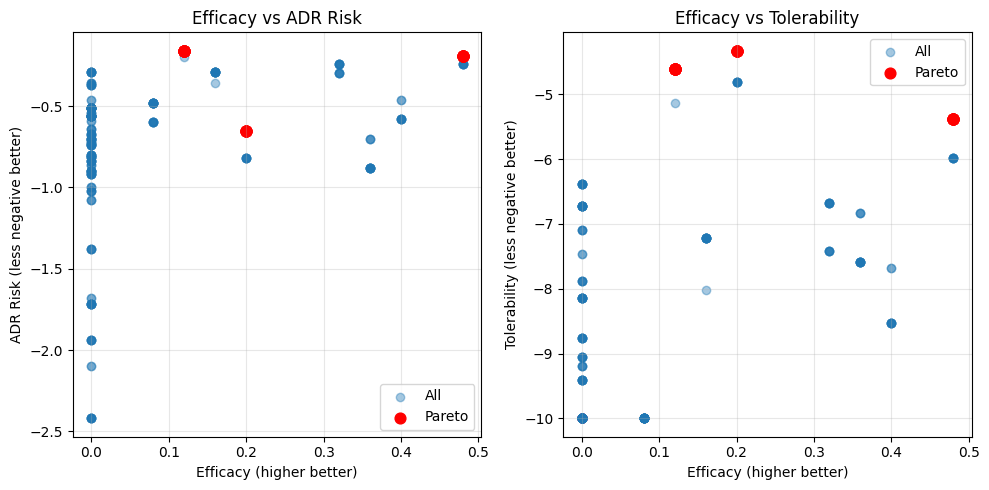

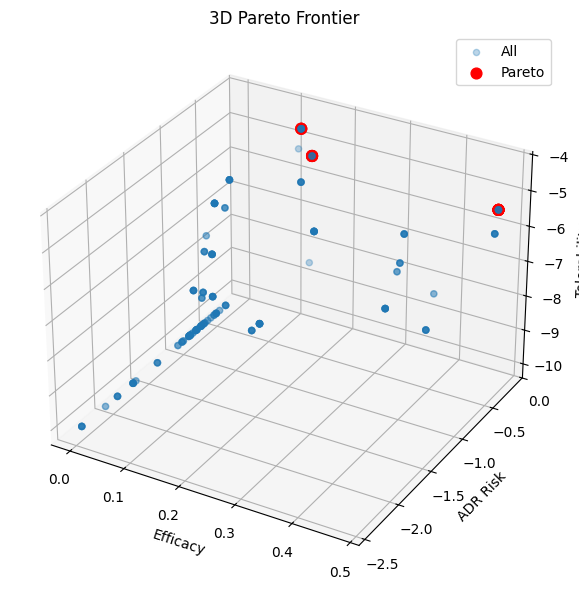


=== PHASE 8 SUMMARY ===
Evaluations: 300 rows
Pareto points: 22
Artifacts saved to /content/drive/MyDrive/ML Patent/polypharmacy_project/outputs


In [ ]:
# =============================================================================
# PHASE 8: EVALUATION & PARETO FRONT ANALYSIS (FIXED)
# =============================================================================

import os
import glob
import json
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
import torch as th  # Added for the fix

import gymnasium as gym
from gymnasium import spaces

from morl_baselines.multi_policy.gpi_pd.gpi_pd import GPIPD

# -------------------------
# Paths and configuration
# -------------------------
BASE_PATH = '/content/drive/MyDrive/ML Patent/polypharmacy_project'
OUTPUT_PATH = os.path.join(BASE_PATH, 'outputs')

MODEL_GLOB = os.path.join(OUTPUT_PATH, 'gpipd_model_*.tar')
MODEL_TABLE = os.path.join(OUTPUT_PATH, 'polypharmacy_model_table.csv')

N_WEIGHTS = 30
EPISODES_PER_WEIGHT = 10
RANDOM_SEED = 42

# -------------------------
# Helpers
# -------------------------
def dirichlet_weights(d: int, n: int, seed: int = 42):
    rng = np.random.default_rng(seed)
    a = rng.gamma(shape=1.0, scale=1.0, size=(n, d))
    return (a / a.sum(axis=1, keepdims=True)).astype(np.float32)

def is_pareto_efficient(points: np.ndarray):
    N = points.shape[0]
    mask = np.ones(N, dtype=bool)
    for i in range(N):
        if mask[i]:
            mask[mask] = np.any(points[mask] > points[i], axis=1) | np.all(points[mask] == points[i], axis=1)
            mask[i] = True
    return mask

# -------------------------
# Load model table (test split)
# -------------------------
df = pd.read_csv(MODEL_TABLE)
np.random.seed(RANDOM_SEED)
idx = np.random.permutation(len(df))
split = int(0.8 * len(df))
test_df = df.iloc[idx[split:]].reset_index(drop=True)

# -------------------------
# Recreate environment
# -------------------------
class PolypharmacyEnv(gym.Env):
    def __init__(self, df: pd.DataFrame):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.n = len(self.df)
        self.observation_space = spaces.Box(0.0, 1.0, shape=(5,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self.reward_space = spaces.Box(
            low=np.array([-1.0, -10.0, -10.0], dtype=np.float32),
            high=np.array([1.0, 0.0, 0.0], dtype=np.float32),
            dtype=np.float32
        )
        self.idx = None
        self.current_hadm_id = None

    def _obs(self, row):
        return np.array([
            np.clip(row['age'] / 100.0, 0, 1),
            np.clip(row['n_drugs'] / 50.0, 0, 1),
            np.clip(row['ddi_count'] / 100.0, 0, 1),
            np.clip(row['major_count'] / 10.0, 0, 1),
            np.clip(row['moderate_count'] / 20.0, 0, 1)
        ], dtype=np.float32)

    def _reward(self, row, action):
        n_drugs = float(row['n_drugs'])
        ddi_count = float(row['ddi_count'])
        major_count = float(row['major_count'])
        total_se = float(row.get('total_se', 0.0))

        efficacy = 1.0 - min(abs(n_drugs - 5.0) / 25.0, 1.0)
        adr_risk = -(ddi_count + 3.0 * major_count) / 50.0
        tolerability = -total_se / 1000.0

        if action == 0:  # reduce_risk
            adr_risk *= 0.8
            tolerability *= 0.9

        r = np.array([efficacy, adr_risk, tolerability], dtype=np.float32)
        return np.clip(r, self.reward_space.low, self.reward_space.high)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.idx = np.random.randint(0, self.n)
        row = self.df.iloc[self.idx]
        self.current_hadm_id = int(row['hadm_id'])
        return self._obs(row), {"hadm_id": self.current_hadm_id}

    def step(self, action):
        row = self.df.iloc[self.idx]
        reward = self._reward(row, int(action))
        terminated, truncated = True, False
        obs, info = self.reset()
        info.update({"last_hadm_id": self.current_hadm_id})
        return obs, reward, terminated, truncated, info

test_env = PolypharmacyEnv(test_df)

# -------------------------
# Load latest trained agent
# -------------------------
model_files = glob.glob(MODEL_GLOB)
if not model_files:
    raise FileNotFoundError("No trained GPIPD model found. Train Phase 7 first.")

latest_model = max(model_files, key=os.path.getmtime)
print(f"Loading model: {latest_model}")

agent = GPIPD(
    env=test_env,
    learning_rate=3e-4,
    gamma=0.99,
    batch_size=256,
    net_arch=[128, 128],
    buffer_size=50_000,
    initial_epsilon=0.05,
    final_epsilon=0.05,
    log=False,
    dyna=False
)
agent.load(latest_model)

# =============================================================================
# BUG FIX: Convert weight_support from NumPy to Tensor
# =============================================================================
# When loading, the weights might come back as numpy arrays.
# GPIPD requires them to be tensors on the correct device.
agent.weight_support = [
    th.tensor(w, device=agent.device, dtype=th.float32)
    if isinstance(w, np.ndarray) else w
    for w in agent.weight_support
]
# =============================================================================

# -------------------------
# Evaluation sweep
# -------------------------
weights = dirichlet_weights(d=3, n=N_WEIGHTS, seed=RANDOM_SEED)

results = []
# Use the weight vector w directly
for wi, w in enumerate(tqdm(weights, desc="Evaluating weights")):
    for epi in range(EPISODES_PER_WEIGHT):
        obs, info = test_env.reset()
        done = False
        ep_reward = np.zeros(3, dtype=np.float32)
        actions = []
        while not done:
            # Agent.eval automatically handles casting input 'w' to tensor
            # provided agent.weight_support is already correct (which we fixed above).
            action = int(agent.eval(obs, w))

            obs, r, done, truncated, info2 = test_env.step(action)
            ep_reward += r
            actions.append(action)

        results.append({
            "weight_index": wi,
            "episode_index": epi,
            "w0": float(w[0]), "w1": float(w[1]), "w2": float(w[2]),
            "efficacy": float(ep_reward[0]),
            "adr_risk": float(ep_reward[1]),
            "tolerability": float(ep_reward[2]),
            "actions": actions
        })

res_df = pd.DataFrame(results)

# -------------------------
# Pareto front computation
# -------------------------
points = res_df[["efficacy", "adr_risk", "tolerability"]].values
mask = is_pareto_efficient(points)
pareto_df = res_df[mask].reset_index(drop=True)

# -------------------------
# Save artifacts
# -------------------------
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
res_path = os.path.join(OUTPUT_PATH, f"phase8_evaluation_{timestamp}.csv")
pareto_path = os.path.join(OUTPUT_PATH, f"phase8_pareto_{timestamp}.csv")
res_df.to_csv(res_path, index=False)
pareto_df.to_csv(pareto_path, index=False)

# -------------------------
# Visualizations
# -------------------------
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(res_df["efficacy"], res_df["adr_risk"], alpha=0.4, label="All")
plt.scatter(pareto_df["efficacy"], pareto_df["adr_risk"], color="red", label="Pareto", s=60)
plt.xlabel("Efficacy (higher better)")
plt.ylabel("ADR Risk (less negative better)")
plt.title("Efficacy vs ADR Risk")
plt.grid(alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(res_df["efficacy"], res_df["tolerability"], alpha=0.4, label="All")
plt.scatter(pareto_df["efficacy"], pareto_df["tolerability"], color="red", label="Pareto", s=60)
plt.xlabel("Efficacy (higher better)")
plt.ylabel("Tolerability (less negative better)")
plt.title("Efficacy vs Tolerability")
plt.grid(alpha=0.3)
plt.legend()

plot2d_path = os.path.join(OUTPUT_PATH, f"phase8_pareto_2d_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot2d_path, dpi=300, bbox_inches="tight")
plt.show()

# 3D plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(res_df["efficacy"], res_df["adr_risk"], res_df["tolerability"], alpha=0.3, label="All")
ax.scatter(pareto_df["efficacy"], pareto_df["adr_risk"], pareto_df["tolerability"], color="red", s=60, label="Pareto")
ax.set_xlabel("Efficacy")
ax.set_ylabel("ADR Risk")
ax.set_zlabel("Tolerability")
ax.set_title("3D Pareto Frontier")
ax.legend()
plot3d_path = os.path.join(OUTPUT_PATH, f"phase8_pareto_3d_{timestamp}.png")
plt.tight_layout()
plt.savefig(plot3d_path, dpi=300, bbox_inches="tight")
plt.show()

# -------------------------
# Summary
# -------------------------
summary = {
    "timestamp": timestamp,
    "n_eval_rows": int(len(res_df)),
    "n_pareto": int(len(pareto_df)),
    "means": {
        "efficacy": float(res_df["efficacy"].mean()),
        "adr_risk": float(res_df["adr_risk"].mean()),
        "tolerability": float(res_df["tolerability"].mean())
    }
}

print("\n=== PHASE 8 SUMMARY ===")
print(f"Evaluations: {len(res_df)} rows")
print(f"Pareto points: {len(pareto_df)}")
print(f"Artifacts saved to {OUTPUT_PATH}")